# LP2: Vodafone Customer Churn Prediction

## Business Understanding

### 1. Project Description/Background

> Given the large number of customers the Telecommunication industry service providers have and the competitive nature of their products/services, the rate at which customers can stop using one provider's product/service in preference for another provider is high. Moreover, the providers can't afford the time to have dedicated attention to each client so that they know when they are dissatified with their products/services and the cost of acquiring a new client as compared to maintaining an existing one is very high.
>
> Therefore, Telcos have a pressing need to use their data from customer interactions to predict with high accuracy the customers that are likely to switch from using their products/services so that they can invest in mitigation startegies to maintain those clients, thereby, increasing their market position and profits.
>
> In this project we utilize the Vodafone Corporation data and Machine Learning models to predict with high accuracy the likelihood of a customer stopping the use of its products/services. We will also identify the factors affecting customer churn and suggest strategies the Telco can deploy to retain a high percentage of its customers. 

#### 2. Features
There are 17 categorical features:

> - CustomerID: Unique identifier for each customer
> - gender: Whether the customer is a male or a female
> - SeniorCitizen: Whether the customer is a senior citizen or not (1, 0)
> - Partner: Whether the customer has a partner or not (Yes, No)
> - Dependent: Whether the customer has dependents or not (Yes, No)
> - PhoneService: Whether the customer has a phone service or not (Yes, No)
> - MultipeLines: Whether the customer has multiple lines (Yes, No, No phone service)
> - InternetService: Customer’s internet service provider (DSL, Fiber optic, No)
> - OnlineSecurity: Whether the customer has online security (Yes, No, No internet service)
> - OnlineBackup: Whether the customer has an online backup (Yes, No, No internet service)
> - DeviceProtection: Whether the customer has device protection (Yes, No, No internet service)
> - TechSupport: Whether the customer has tech support (Yes, No, No internet service)
> - StreamingTV: Whether the customer streams TV (Yes, No, No internet service)
> - StreamingMovies: Whether the customer streams movies (Yes, No, No internet service)
> - Contract: The contract term of the customer (Month-to-month, One year, Two years)
> - PaperlessBilling: Whether the customer does paperless Billing or not (True, False)
> - PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))

Next, there are 3 numerical features:

> - Tenure: Number of months the customer has stayed with the company
> - MonthlyCharges: The amount charged to the customer monthly
> - TotalCharges: The total amount charged to the customer

Finally, there’s a prediction feature:

> - Churn: Whether the customer churned or not (Yes or No)

These features can also be subdivided into:

**Demographic customer information:**
> gender , SeniorCitizen , Partner , Dependents

**Services that each customer has signed up for:**
> PhoneService , MultipleLines , InternetService , OnlineSecurity , OnlineBackup , DeviceProtection , TechSupport , StreamingTV , StreamingMovies,

**Customer account information:**
> tenure , Contract , PaperlessBilling , PaymentMethod , MonthlyCharges , TotalCharges

### 3. Hypothesis

> **Null Hypothesis:** Contract duration has no effect on the probability of customer churn.
>
> **Alternative Hypothesis:** Contract duration significantly affects the probability of customer churn.

### 4. Analytical Questions
> 1. Does the monthly and total charges affect the probability of a customer churning?
> 1. How does contract duration affect the probability of a customer churning?
> 1. How likely are customers with a tenure of more than 5 years likely to churn?
> 1. Which payment method has the customers with the highest churn rate?
> 1. Which demographic factor(s) most affects the customer churn rate?
> 1. Which customer service has the highest churn rate?

## Data Understanding

### 1. Installing Packages and Importing Modules

In [160]:
#importing modules

import pyodbc      #just installed with pip
from dotenv import dotenv_values    #import the dotenv_values function from the dotenv package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings 
import scipy
import statsmodels.api as sm
from scipy.stats import chi2_contingency as chi2
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,LabelEncoder, FunctionTransformer,PowerTransformer
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score,confusion_matrix,roc_auc_score,roc_curve
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from numpy import log1p
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectKBest, mutual_info_classif

pd.set_option('display.max_columns', None)

# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

In [98]:
# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [99]:
# Establish a connection
connection = pyodbc.connect(connection_string)

### 2. Loading Data

In [100]:
# SQL query to fetch data from 'dbo.LP2_Telco_churn_first_3000' table
query = "Select * from dbo.LP2_Telco_churn_first_3000"

# Read data from the SQL query result
first_3000data = pd.read_sql(query, connection)
first_3000data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [101]:
testdata = pd.read_excel('Telco-churn-second-2000.xlsx')
testdata.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [102]:
second_2000data = pd.read_csv('LP2_Telco-churn-last-2000.csv')
second_2000data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,No,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


### 3. Exploratory Data Analysis

### Merging the first and second data sets

In [103]:
# Concatenate the first and second dataset
combined_data = pd.concat([first_3000data, second_2000data], ignore_index=True)

# Verify the structure of the combined dataset
combined_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [104]:
#observing sample data
combined_data.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3804,1555-HAPSU,Female,0,Yes,Yes,71,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),23.900000,1663.5,No
4296,4023-RTIQM,Female,1,Yes,No,31,No,No phone service,DSL,Yes,Yes,Yes,No,No,Yes,One year,Yes,Credit card (automatic),50.400000,1580.1,No
2627,4213-HKBJO,Female,0,False,False,33,True,True,No,None,None,None,None,None,None,Two year,False,Credit card (automatic),25.700001,826.099976,False
3174,0947-IDHRQ,Female,0,No,No,7,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Mailed check,80.300000,526.7,Yes
4934,6257-DTAYD,Male,0,Yes,No,71,Yes,Yes,Fiber optic,No,Yes,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),104.150000,7365.3,No


In [105]:
# inspecting the combined data
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


> **Observation**
> - The combined dataset has `5,043` records and `21` variables
> - `7` ***categorical Variables***, `1` ***Numerical Variable*** and the ***Target Variable*** have `Missing Values`

### Univariate Data analysis

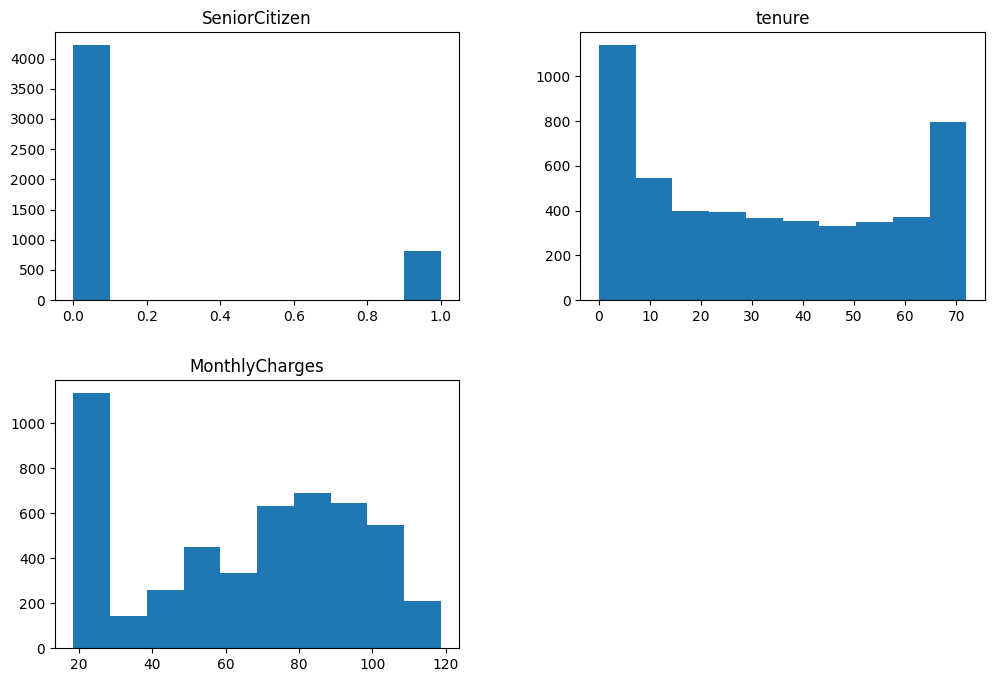

In [106]:
# Visualizing the distribution of Numerical Variables
combined_data.hist(figsize=(12,8), grid= False)
plt.show()

> **Observation**
> - The `SeniorCitizen` variable's data type should be a ***Categorical Variable*** to indicate if the user is a senior citizen or not.
> - From the `SeniorCitizen` variable distribution we can see that most users are not senior citizens.
> - The `Tenure` variable distribution shows that the number of users decreases as the number of years they have been using the company products/services increases up to **50 years** where they then start increasing.
> - Apart from the concentration of most users on the least monthly charges, the `MonthlyCharges` variable is almost ***normally distributed***  



**Univariate Analysis of Feature: customerID**
count           5043
unique          5043
top       7590-VHVEG
freq               1
Name: customerID, dtype: object

Unique Values and Counts:
customerID
7590-VHVEG    1
5143-EGQFK    1
8232-CTLKO    1
0847-HGRML    1
9050-QLROH    1
             ..
5451-MHQOF    1
0999-QXNSA    1
1060-ENTOF    1
3283-WCWXT    1
3186-AJIEK    1
Name: count, Length: 5043, dtype: int64

Missing Values: 0 (0.00%)


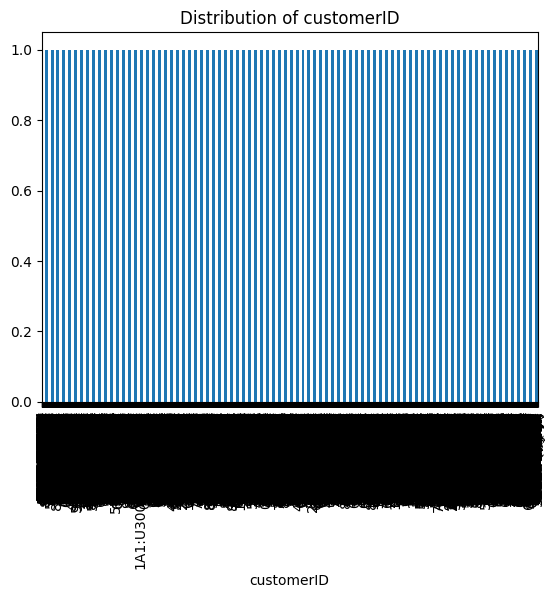


**Univariate Analysis of Feature: gender**
count     5043
unique       2
top       Male
freq      2559
Name: gender, dtype: object

Unique Values and Counts:
gender
Male      2559
Female    2484
Name: count, dtype: int64

Missing Values: 0 (0.00%)


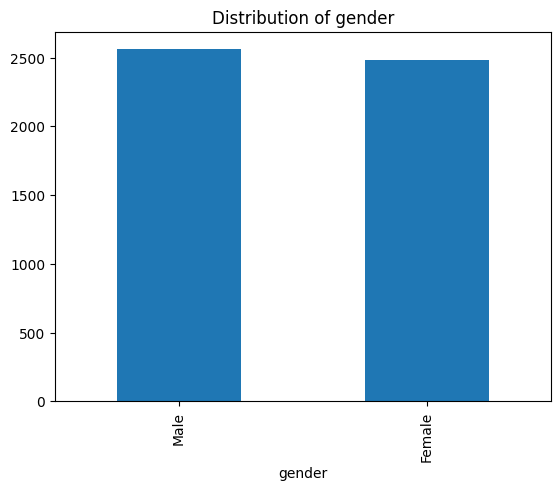


**Univariate Analysis of Feature: Partner**
count      5043
unique        4
top       False
freq       1538
Name: Partner, dtype: object

Unique Values and Counts:
Partner
False    1538
True     1462
No       1047
Yes       996
Name: count, dtype: int64

Missing Values: 0 (0.00%)


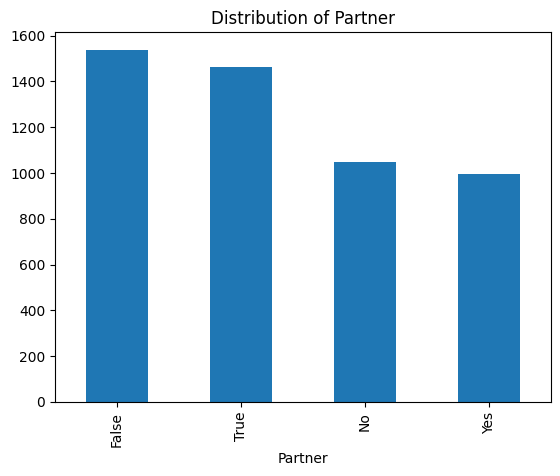


**Univariate Analysis of Feature: Dependents**
count      5043
unique        4
top       False
freq       2070
Name: Dependents, dtype: object

Unique Values and Counts:
Dependents
False    2070
No       1412
True      930
Yes       631
Name: count, dtype: int64

Missing Values: 0 (0.00%)


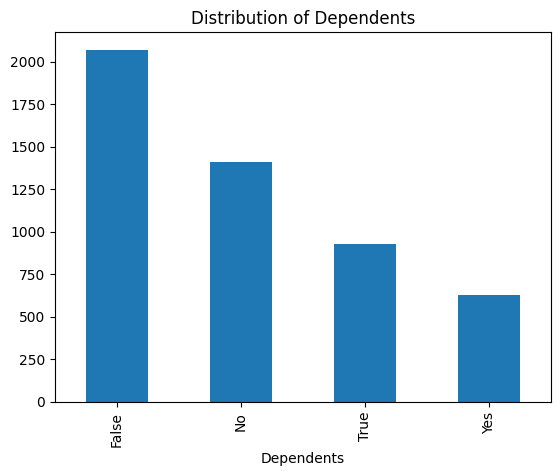


**Univariate Analysis of Feature: PhoneService**
count     5043
unique       4
top       True
freq      2731
Name: PhoneService, dtype: object

Unique Values and Counts:
PhoneService
True     2731
Yes      1823
False     269
No        220
Name: count, dtype: int64

Missing Values: 0 (0.00%)


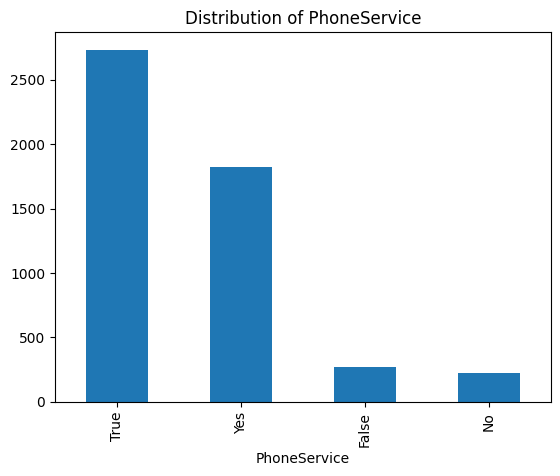


**Univariate Analysis of Feature: MultipleLines**
count      4774
unique        5
top       False
freq       1437
Name: MultipleLines, dtype: object

Unique Values and Counts:
MultipleLines
False               1437
True                1294
No                   987
Yes                  836
No phone service     220
Name: count, dtype: int64

Missing Values: 269 (5.33%)


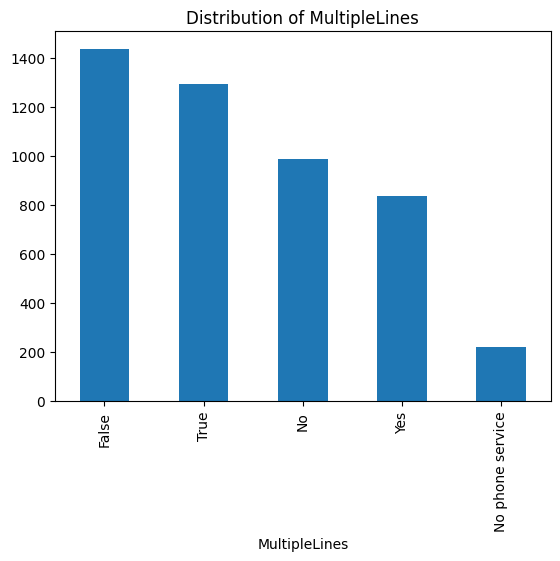


**Univariate Analysis of Feature: InternetService**
count            5043
unique              3
top       Fiber optic
freq             2248
Name: InternetService, dtype: object

Unique Values and Counts:
InternetService
Fiber optic    2248
DSL            1715
No             1080
Name: count, dtype: int64

Missing Values: 0 (0.00%)


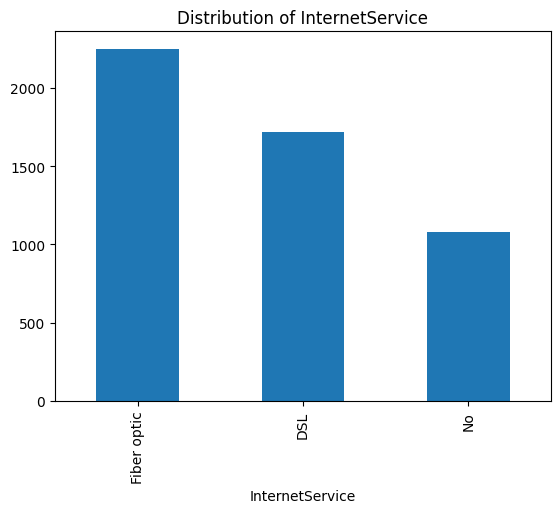


**Univariate Analysis of Feature: OnlineSecurity**
count      4392
unique        5
top       False
freq       1478
Name: OnlineSecurity, dtype: object

Unique Values and Counts:
OnlineSecurity
False                  1478
No                     1029
True                    871
Yes                     585
No internet service     429
Name: count, dtype: int64

Missing Values: 651 (12.91%)


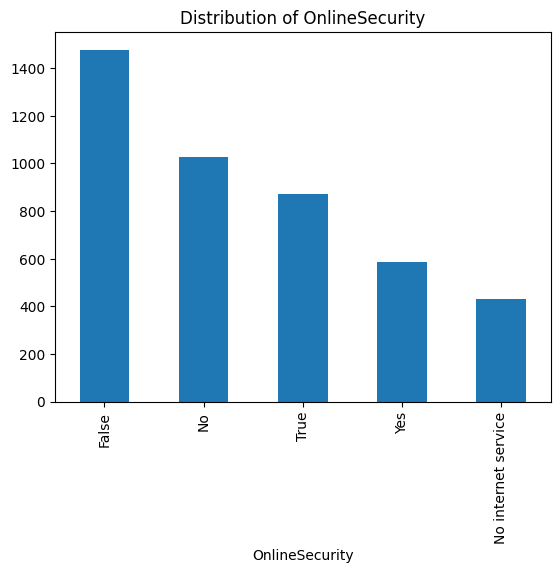


**Univariate Analysis of Feature: OnlineBackup**
count      4392
unique        5
top       False
freq       1320
Name: OnlineBackup, dtype: object

Unique Values and Counts:
OnlineBackup
False                  1320
True                   1029
No                      911
Yes                     703
No internet service     429
Name: count, dtype: int64

Missing Values: 651 (12.91%)


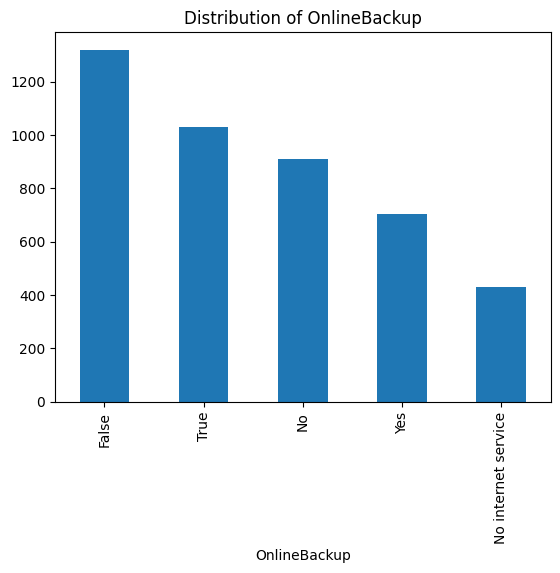


**Univariate Analysis of Feature: DeviceProtection**
count      4392
unique        5
top       False
freq       1296
Name: DeviceProtection, dtype: object

Unique Values and Counts:
DeviceProtection
False                  1296
True                   1053
No                      923
Yes                     691
No internet service     429
Name: count, dtype: int64

Missing Values: 651 (12.91%)


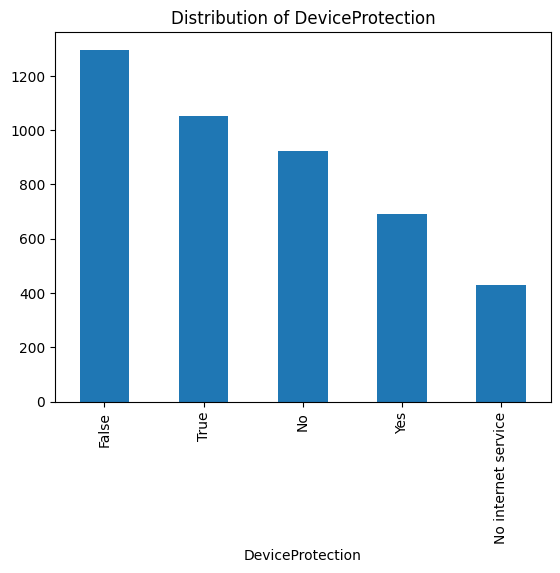


**Univariate Analysis of Feature: TechSupport**
count      4392
unique        5
top       False
freq       1476
Name: TechSupport, dtype: object

Unique Values and Counts:
TechSupport
False                  1476
No                      996
True                    873
Yes                     618
No internet service     429
Name: count, dtype: int64

Missing Values: 651 (12.91%)


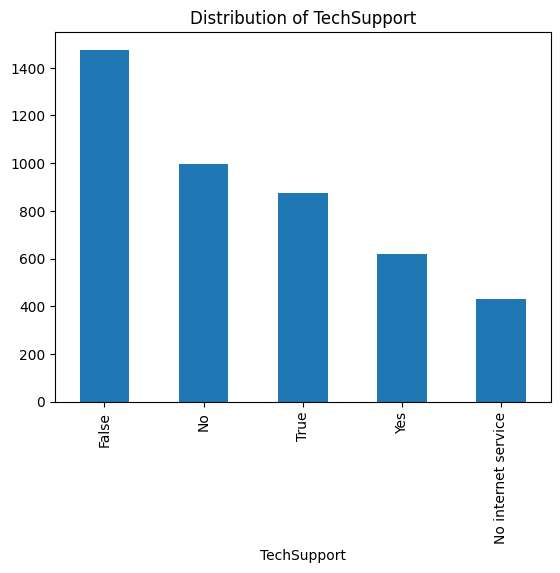


**Univariate Analysis of Feature: StreamingTV**
count      4392
unique        5
top       False
freq       1190
Name: StreamingTV, dtype: object

Unique Values and Counts:
StreamingTV
False                  1190
True                   1159
No                      828
Yes                     786
No internet service     429
Name: count, dtype: int64

Missing Values: 651 (12.91%)


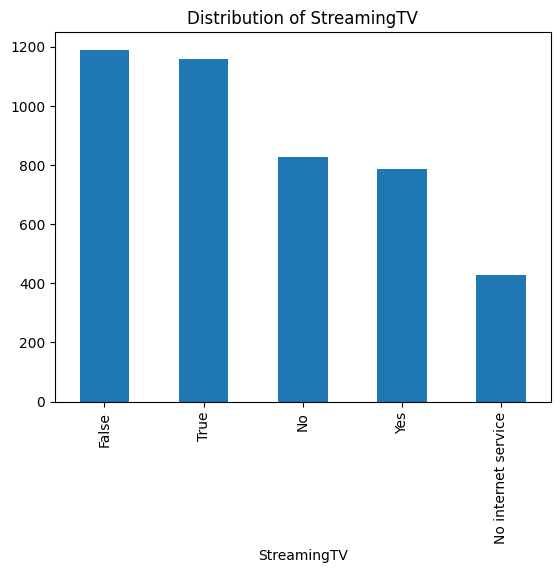


**Univariate Analysis of Feature: StreamingMovies**
count     4392
unique       5
top       True
freq      1199
Name: StreamingMovies, dtype: object

Unique Values and Counts:
StreamingMovies
True                   1199
False                  1150
No                      831
Yes                     783
No internet service     429
Name: count, dtype: int64

Missing Values: 651 (12.91%)


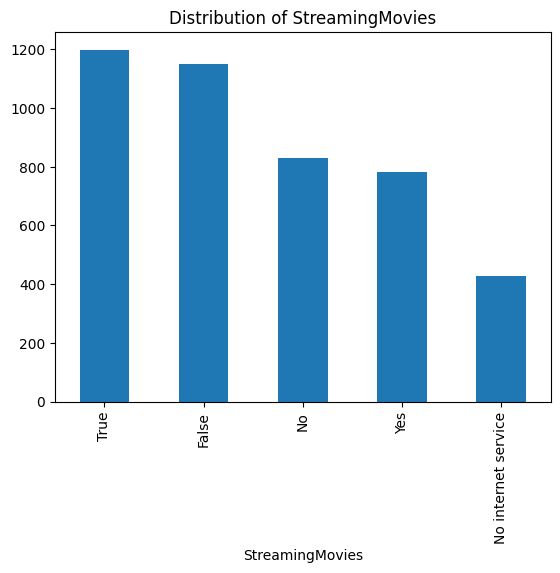


**Univariate Analysis of Feature: Contract**
count               5043
unique                 3
top       Month-to-month
freq                2744
Name: Contract, dtype: object

Unique Values and Counts:
Contract
Month-to-month    2744
Two year          1244
One year          1055
Name: count, dtype: int64

Missing Values: 0 (0.00%)


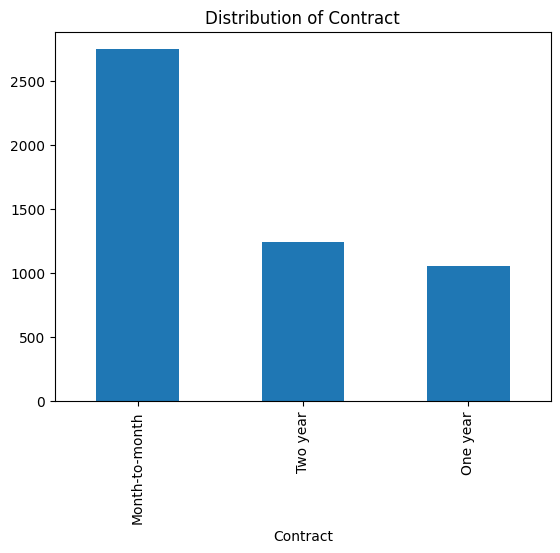


**Univariate Analysis of Feature: PaperlessBilling**
count     5043
unique       4
top       True
freq      1776
Name: PaperlessBilling, dtype: object

Unique Values and Counts:
PaperlessBilling
True     1776
False    1224
Yes      1220
No        823
Name: count, dtype: int64

Missing Values: 0 (0.00%)


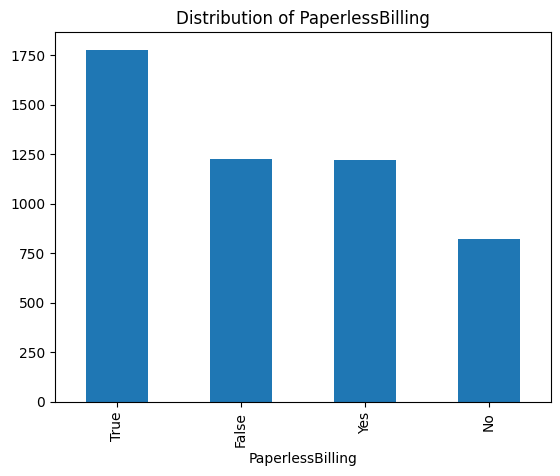


**Univariate Analysis of Feature: PaymentMethod**
count                 5043
unique                   4
top       Electronic check
freq                  1700
Name: PaymentMethod, dtype: object

Unique Values and Counts:
PaymentMethod
Electronic check             1700
Mailed check                 1128
Bank transfer (automatic)    1125
Credit card (automatic)      1090
Name: count, dtype: int64

Missing Values: 0 (0.00%)


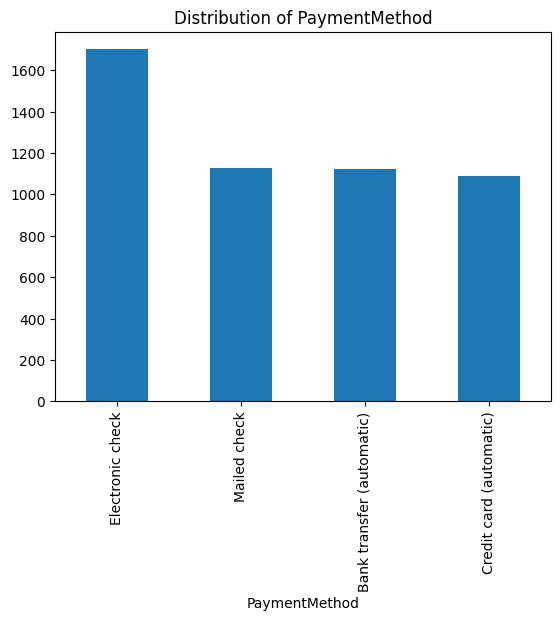


**Univariate Analysis of Feature: TotalCharges**
count     5038.000000
unique    4884.000000
top         20.200001
freq         5.000000
Name: TotalCharges, dtype: float64

Unique Values and Counts:
TotalCharges
20.200000762939453    5
20.450000762939453    5
20.2                  5
19.549999237060547    4
19.65                 4
                     ..
99.75                 1
425.1000061035156     1
2200.25               1
6615.14990234375      1
6844.5                1
Name: count, Length: 4884, dtype: int64

Missing Values: 5 (0.10%)


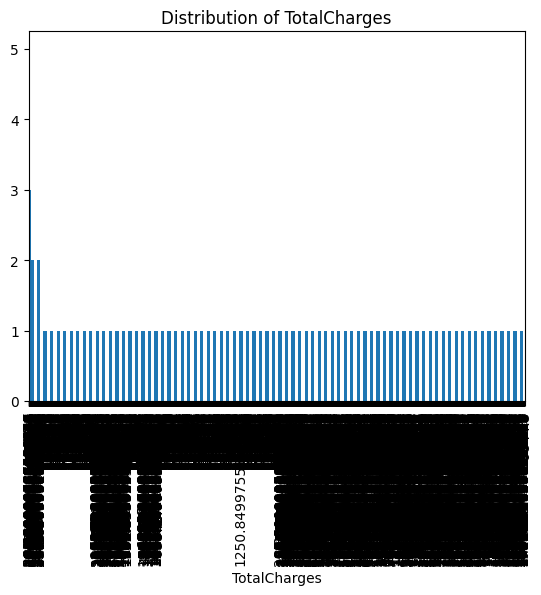


**Univariate Analysis of Feature: Churn**
count      5042
unique        4
top       False
freq       2219
Name: Churn, dtype: object

Unique Values and Counts:
Churn
False    2219
No       1487
True      780
Yes       556
Name: count, dtype: int64

Missing Values: 1 (0.02%)


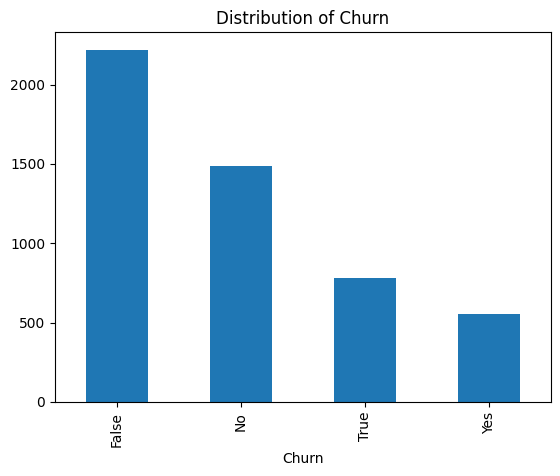

In [107]:
#inspecting the distribution of categorical variables

# List of categorical variables
categorical_features = list(combined_data.select_dtypes(include=["object"]))

# Loop through each categorical variable
for feature in categorical_features:
    # Describe the feature
    print(f"\n**Univariate Analysis of Feature: {feature}**")
    print(combined_data[feature].describe())

    # Print the number of unique values and their corresponding counts
    print("\nUnique Values and Counts:")
    print(combined_data[feature].value_counts())

    # Calculate and print the percentage of missing values
    missing_values_count = combined_data[feature].isnull().sum()
    missing_values_percentage = (missing_values_count / len(combined_data)) * 100
    print(f"\nMissing Values: {missing_values_count} ({missing_values_percentage:.2f}%)")

    # Plot the distribution of the variable
    combined_data[feature].value_counts().plot(kind="bar")
    plt.xlabel(feature)
    plt.title(f"Distribution of {feature}")
    plt.show()

**Observation**
> - The `Yes`/ `True` values and `No`/ `False` values are similar options and need to be merged.
> - The `CustomerID` variable is not important in our anlysis and can do away with it.
> - The `TotalCharges` variable need to be converted to ***numeric***, it's not ***categorical***

#### Fixing Data issues from our univariate data analysis

> **Issue 1: Deleting the `CustomerID` Column**
> > - The column is not important in our analysis.

In [108]:
#code
del combined_data['customerID']

#test
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5043 non-null   object 
 1   SeniorCitizen     5043 non-null   int64  
 2   Partner           5043 non-null   object 
 3   Dependents        5043 non-null   object 
 4   tenure            5043 non-null   int64  
 5   PhoneService      5043 non-null   object 
 6   MultipleLines     4774 non-null   object 
 7   InternetService   5043 non-null   object 
 8   OnlineSecurity    4392 non-null   object 
 9   OnlineBackup      4392 non-null   object 
 10  DeviceProtection  4392 non-null   object 
 11  TechSupport       4392 non-null   object 
 12  StreamingTV       4392 non-null   object 
 13  StreamingMovies   4392 non-null   object 
 14  Contract          5043 non-null   object 
 15  PaperlessBilling  5043 non-null   object 
 16  PaymentMethod     5043 non-null   object 


> **Issue 2: Converting `SeniorCitizen` column's datatype to _categorical Variable_**
> > - the data type for this columns is categorical

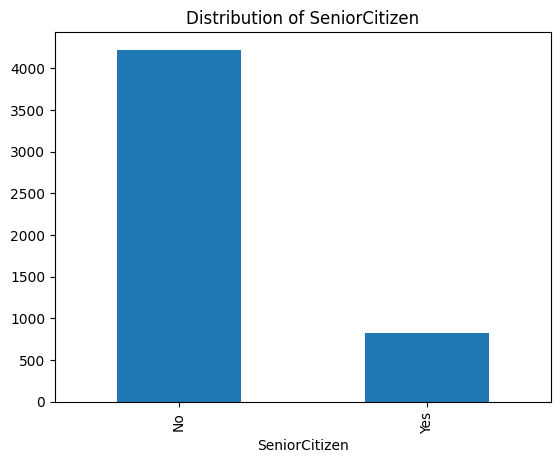

In [109]:
#code 
#Convert 'SeniorCitizen' to categorical variable in second dataset
combined_data['SeniorCitizen'] = combined_data['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

#test
# Plot the distribution of the SeniorCitizen
combined_data['SeniorCitizen'].value_counts().plot(kind="bar")
plt.xlabel('SeniorCitizen')
plt.title(f"Distribution of {'SeniorCitizen'}")
plt.show()

> **Issue 3: Synchronizing the `Yes`/ `True` and `No`/ `False`values for categorical variables** 
> > - These value pairs mean the same thing and need to be merged

In [110]:
#code
# Convert columns to bool in second dataset
category = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
combined_data[category] = combined_data[category].replace({True: 'Yes', False: 'No'})

#test
combined_data[category].nunique()

Partner             2
Dependents          2
PhoneService        2
MultipleLines       3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
PaperlessBilling    2
dtype: int64

> **Issue 4: Synchronizing the `Yes`/ `True` and `No`/ `False`values for the _Churn_ variable** 
> > - These value pairs mean the same thing and need to be merged

In [111]:
#code
combined_data['Churn'] = combined_data['Churn'].replace({ True: 'Yes', False: 'No'})

#test
combined_data['Churn'].nunique()

2

> **Issue 5: Converting `TotalCharges` column's datatype to _numeric_**
> > - This column's data type is numeric, some erronic entries are the one making it to be detected as Object 

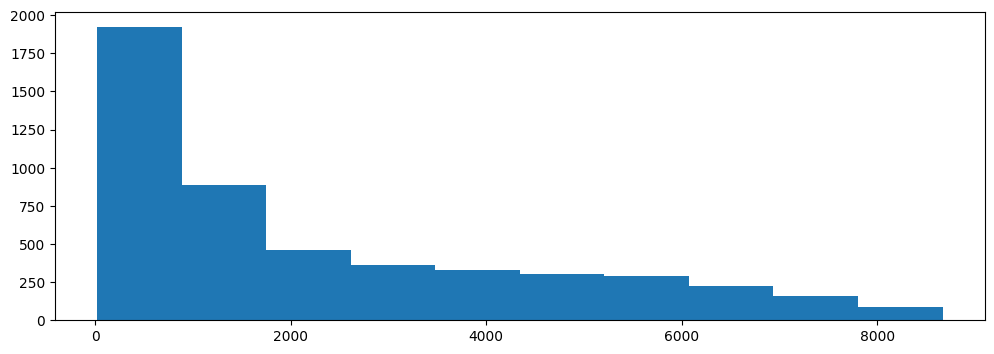

In [112]:
#code
# Convert 'TotalCharges' column to numeric, replacing non-numeric values with NaN
combined_data['TotalCharges'] = pd.to_numeric(combined_data['TotalCharges'], errors='coerce')

#test
combined_data['TotalCharges'].hist(figsize=(12,4), grid= False)
plt.show()

> **Observation**
> - The number of users decrease as the total charges increase. They have an inverse proportionality relationship.

### Bi-variate Data Analysis

In [113]:
#investigating the dataset
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5043 non-null   object 
 1   SeniorCitizen     5043 non-null   object 
 2   Partner           5043 non-null   object 
 3   Dependents        5043 non-null   object 
 4   tenure            5043 non-null   int64  
 5   PhoneService      5043 non-null   object 
 6   MultipleLines     4774 non-null   object 
 7   InternetService   5043 non-null   object 
 8   OnlineSecurity    4392 non-null   object 
 9   OnlineBackup      4392 non-null   object 
 10  DeviceProtection  4392 non-null   object 
 11  TechSupport       4392 non-null   object 
 12  StreamingTV       4392 non-null   object 
 13  StreamingMovies   4392 non-null   object 
 14  Contract          5043 non-null   object 
 15  PaperlessBilling  5043 non-null   object 
 16  PaymentMethod     5043 non-null   object 


#### Bivariate analysis of Categorical Variables

In [114]:
# Convert churn target variable to integer
combined_data['Churn'] = combined_data['Churn'].replace({'Yes': 1, 'No': 0})
 

##### Distribution of `Churn Percentage` among `Categorical Variable`


**Churn Percentage by gender Category:
   gender      Churn
0  Female  26.610306
1    Male  26.387803


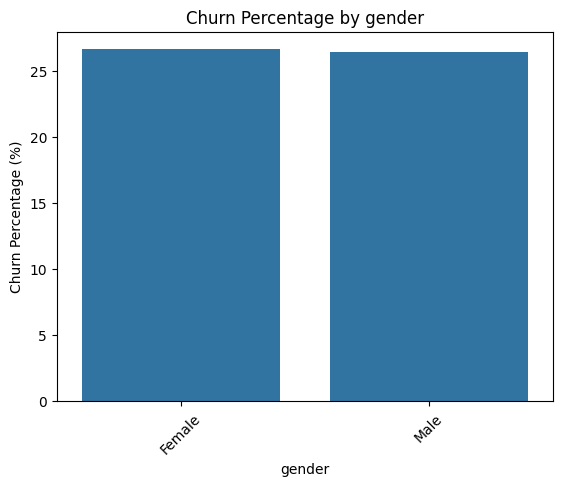


**Churn Percentage by SeniorCitizen Category:
  SeniorCitizen      Churn
1           Yes  41.514042
0            No  23.585129


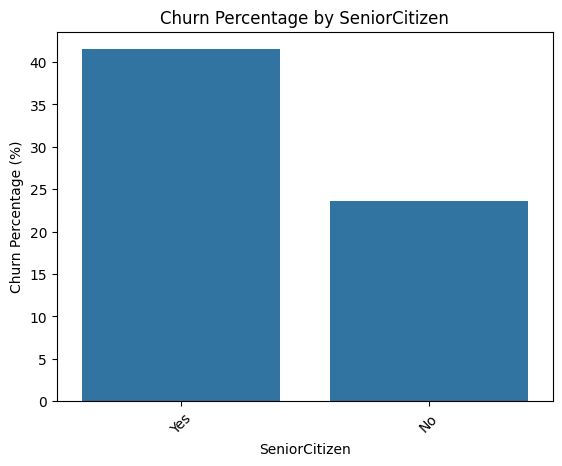


**Churn Percentage by Partner Category:
  Partner      Churn
0      No  32.572534
1     Yes  20.105820


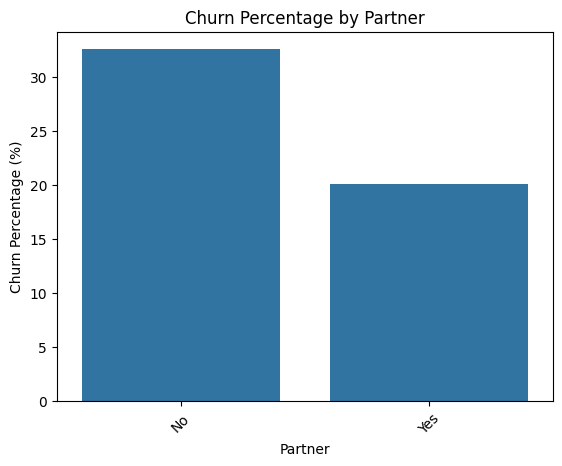


**Churn Percentage by Dependents Category:
  Dependents      Churn
0         No  31.571388
1        Yes  15.182575


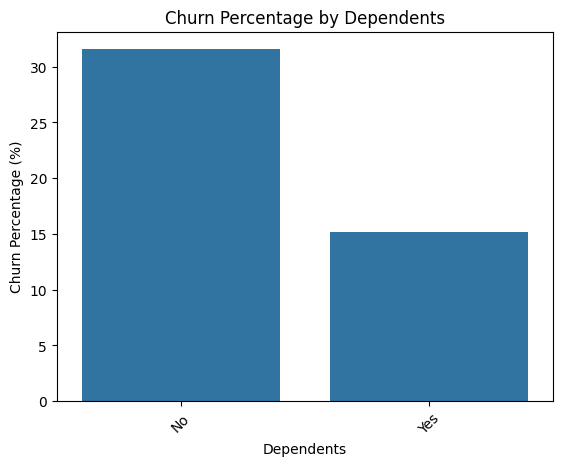


**Churn Percentage by PhoneService Category:
  PhoneService      Churn
1          Yes  26.707665
0           No  24.539877


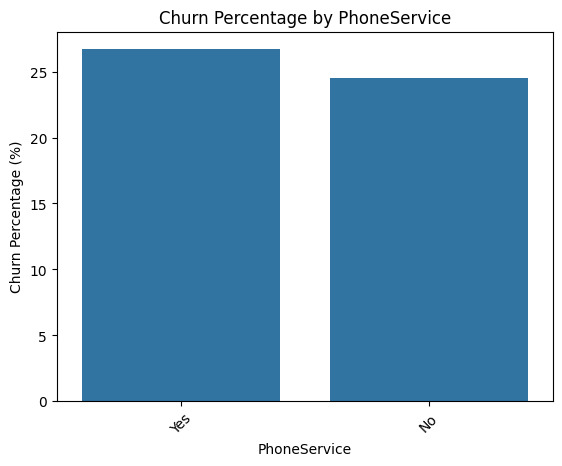


**Churn Percentage by MultipleLines Category:
      MultipleLines      Churn
2               Yes  28.604979
0                No  25.041254
1  No phone service  25.000000


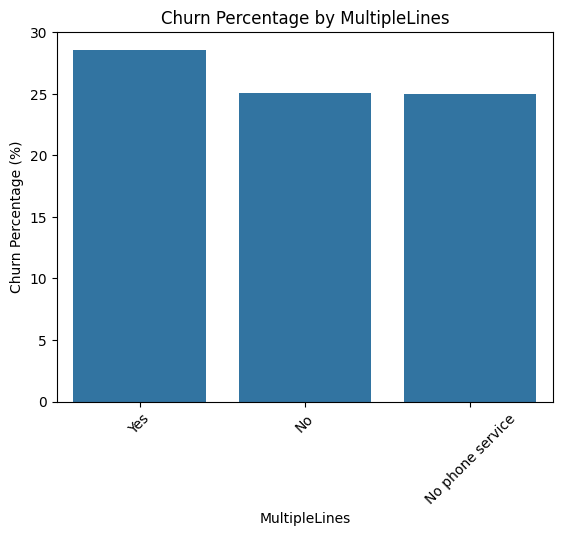


**Churn Percentage by InternetService Category:
  InternetService      Churn
1     Fiber optic  42.323097
0             DSL  18.017493
2              No   7.037037


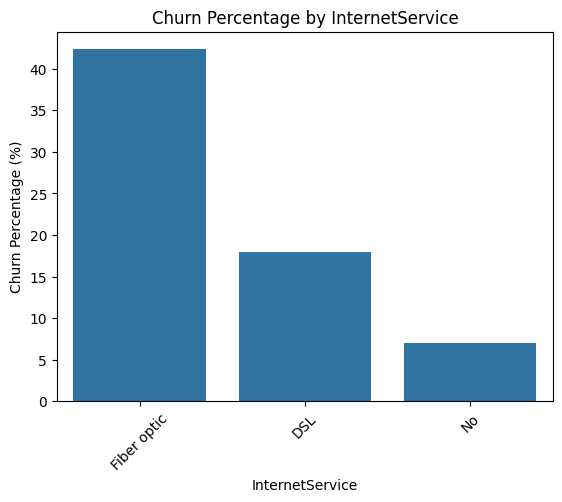


**Churn Percentage by OnlineSecurity Category:
        OnlineSecurity      Churn
0                   No  41.723175
2                  Yes  14.707904
1  No internet service   8.624709


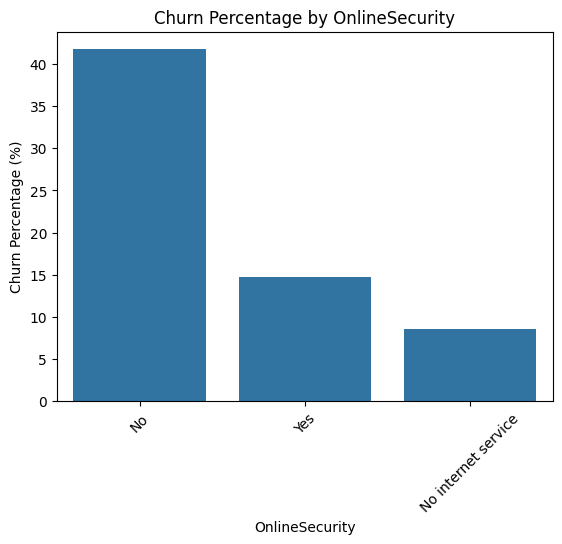


**Churn Percentage by OnlineBackup Category:
          OnlineBackup      Churn
0                   No  39.937248
2                  Yes  21.317158
1  No internet service   8.624709


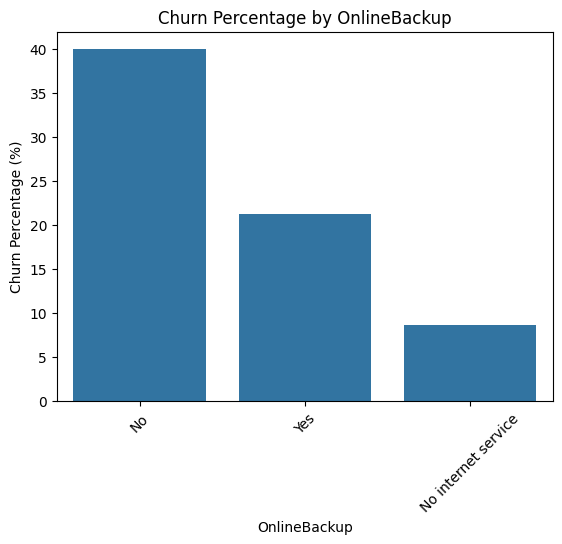


**Churn Percentage by DeviceProtection Category:
      DeviceProtection      Churn
0                   No  39.071654
2                  Yes  22.547332
1  No internet service   8.624709


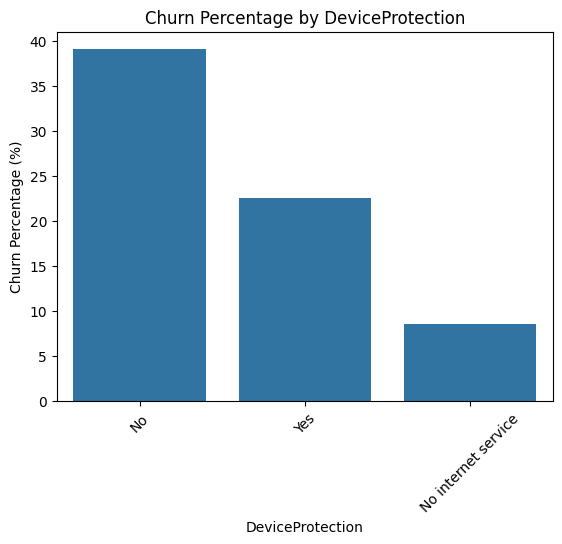


**Churn Percentage by TechSupport Category:
           TechSupport      Churn
0                   No  42.047754
2                  Yes  14.822267
1  No internet service   8.624709


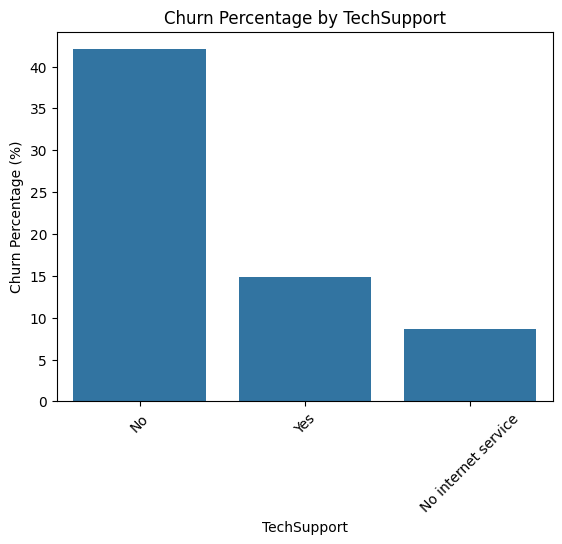


**Churn Percentage by StreamingTV Category:
           StreamingTV      Churn
0                   No  33.448959
2                  Yes  30.092593
1  No internet service   8.624709


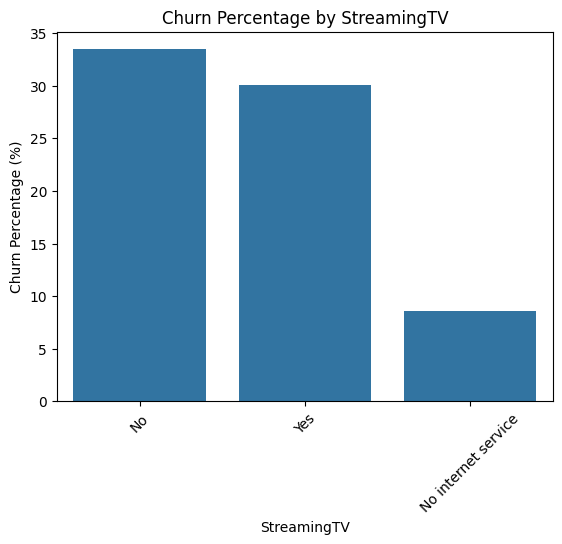


**Churn Percentage by StreamingMovies Category:
       StreamingMovies      Churn
0                   No  33.013629
2                  Yes  30.590611
1  No internet service   8.624709


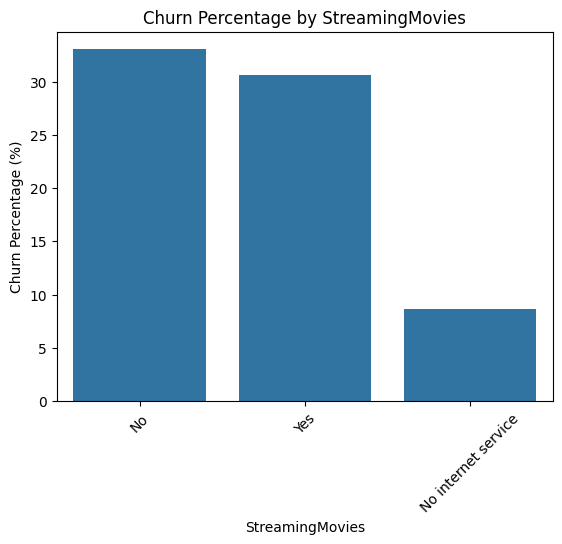


**Churn Percentage by Contract Category:
         Contract      Churn
0  Month-to-month  43.148688
1        One year  11.563981
2        Two year   2.413516


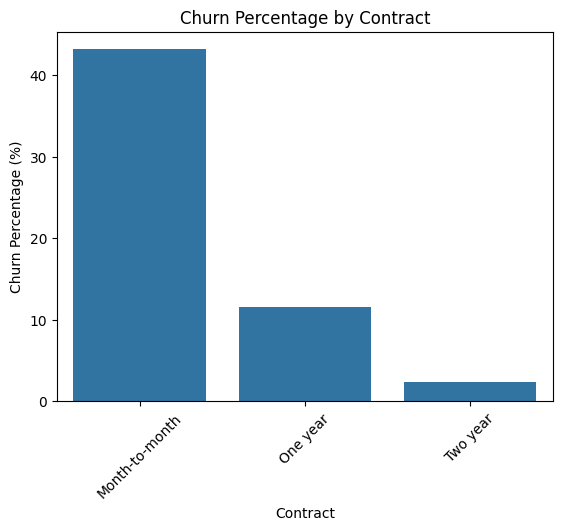


**Churn Percentage by PaperlessBilling Category:
  PaperlessBilling      Churn
1              Yes  33.555927
0               No  16.170005


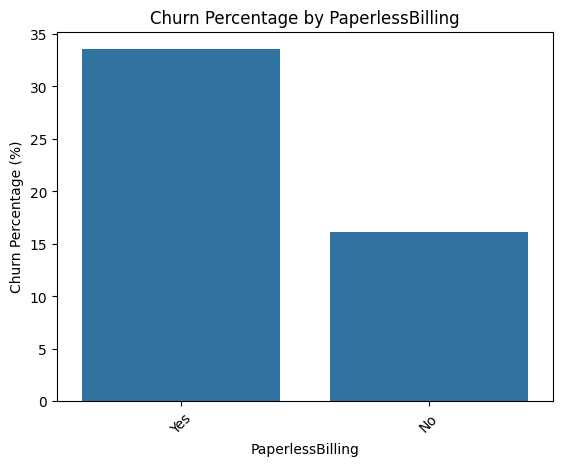


**Churn Percentage by PaymentMethod Category:
               PaymentMethod      Churn
2           Electronic check  44.614479
3               Mailed check  18.794326
0  Bank transfer (automatic)  17.600000
1    Credit card (automatic)  15.412844


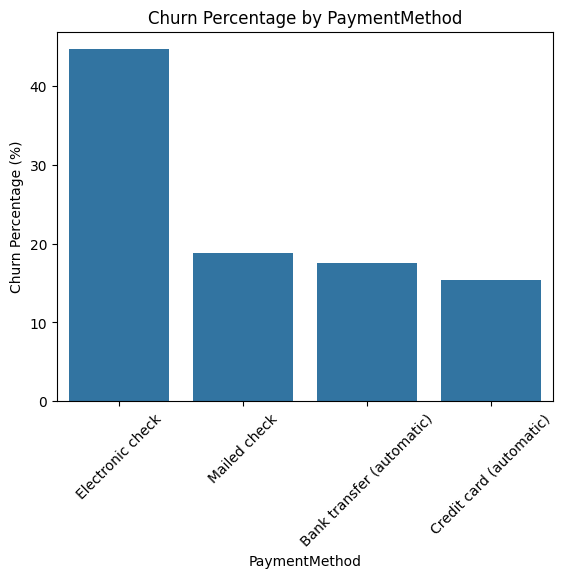

In [115]:
# Define categorical features
categorical_features = list(combined_data.select_dtypes(include=["object","bool"]))

# Function for bivariate analysis of categorical features
def analyze_categorical_feature(feature):
    # Calculate churn percentage for each category
    churn_pct_by_category = (
        combined_data.groupby(feature)["Churn"].mean() * 100
    ).reset_index()
    
    # Sort categories by churn percentage
    churn_pct_by_category = churn_pct_by_category.sort_values(by="Churn", ascending=False)

    # Print results
    print(f"\n**Churn Percentage by {feature} Category:")
    print(churn_pct_by_category)

    # Plot the churn percentage by category
    sn.barplot(x=feature, y="Churn", data=churn_pct_by_category)
    plt.xlabel(feature)
    plt.ylabel("Churn Percentage (%)")
    plt.title(f"Churn Percentage by {feature}")
    plt.xticks(rotation= 45 )
    plt.show()

# Loop through each categorical feature and perform bivariate analysis
for feature in categorical_features:
    analyze_categorical_feature(feature)

> **Observations**
> > **Demographic Variables Insights**
> > > - `Gender`: The churn rate among gender categories was almost similar at __27.3%__ for male users and __27.1__ among female users.
> > > - `SeniorCitizens`: SeniorCitizen users were more likely to churn at __43%__ compared to non-SeniorCitizens at __24%__
> > > - `Partners` & `Dependents`: Users without partners and dependants churned more(__33%__ and __32.2%__) than those with partners and dependants who churned at __20.8%__ and __15.8%__ respectively.
>
> > **Services Subscribed Variables Insights**
> > > - `PhoneService` & `MultipleLines`: Customers with a phone service and multiple lines had a slighty higher propensity to churn, __27.5%__ and __29.4%__ than those without a phone service at __25%__ and those without multiple lines at __25.8%__
> > > - `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`,`TechSupport`,`StreamingTV`, `StreamingMovies`: Cusomers who had *Fibre Optic* internet and those who did not subscribe to these services churned the most with rates of; __42%, 41.7%, 40%, 38.6%, 41%, 33.7%, 33.8%__ respectively. Users with no internet charned at __8.6%__
>
> > **Customer Account Info Variables Insights**
> > > - `Contract`, `PaperlessBilling`, `PaymentMethod`: Cusomers with Month-on-month contracts, Paperless Billings and electronic check payments churned the most with rates of; __43.8%, 34.3%, and 44.3__ respectively. 

#### Bivariate analysis of Numerical Variables

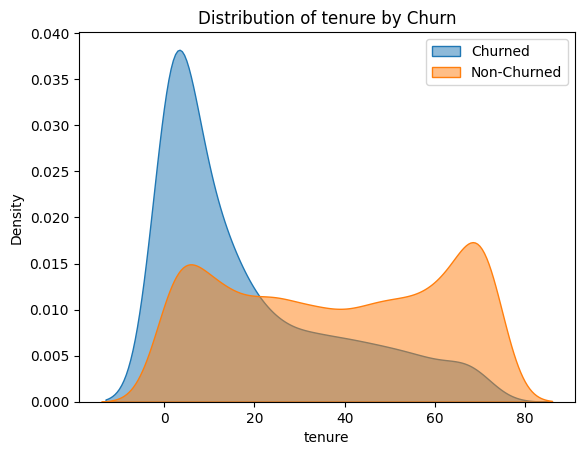

Correlation coefficient between tenure and Churn: -0.3508


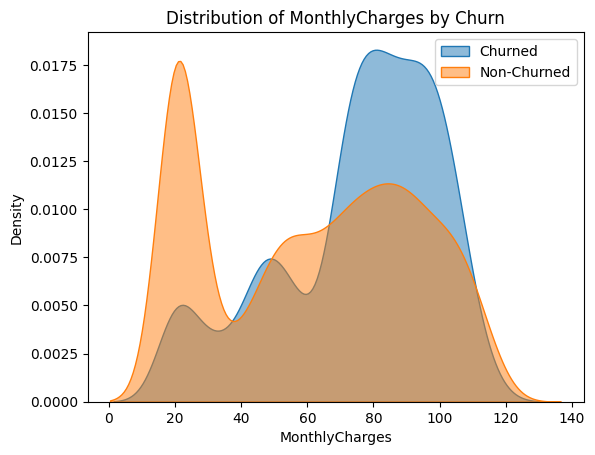

Correlation coefficient between MonthlyCharges and Churn: 0.2023


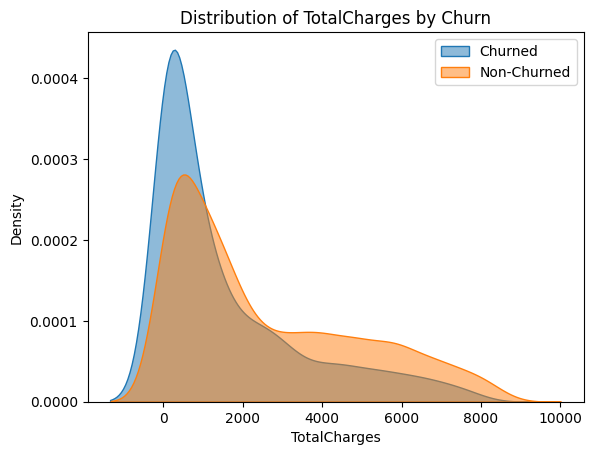

Correlation coefficient between TotalCharges and Churn: -0.1946


In [116]:
# Define numerical features
numerical_features = combined_data[['tenure','MonthlyCharges','TotalCharges']]

# Bivariate analysis for numerical features
for feature in numerical_features:
    # Plot the distribution of the feature for churned and non-churned customers
    sn.kdeplot(
        combined_data[combined_data["Churn"] == 1][feature], label="Churned", shade=True, alpha=0.5
    )
    sn.kdeplot(
        combined_data[combined_data["Churn"] == 0][feature], label="Non-Churned", shade=True, alpha=0.5
    )
    
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.title(f"Distribution of {feature} by Churn")
    plt.legend()
    plt.show()

    # Calculate the correlation coefficient between the feature and Churn
    correlation = combined_data[feature].corr(combined_data["Churn"])
    print(f"Correlation coefficient between {feature} and Churn: {correlation:.4f}")
    

> **Observations**
> > **User Account Info Variables Insights**
> > > - `Tenure`: As the number of years that a customer has been using the company's products/services increases, the chances of them stopping the usage of their products/services decreases. This  is further shown by the `-0.35` correlation coefficient.
> > > - `MonthlyCharges`: The rate of churn in the Monthly charges variable is positive, showing that as the total monthly charges for a user increases, they are more likely to churn. The `0.188` correlation coeffient supports that weakly.
> > > - `TotalCharges`: As the Total charges for a user increase, their churn rate decreases as indicated by the `-0.196`weak correlation coefficient.

<Axes: >

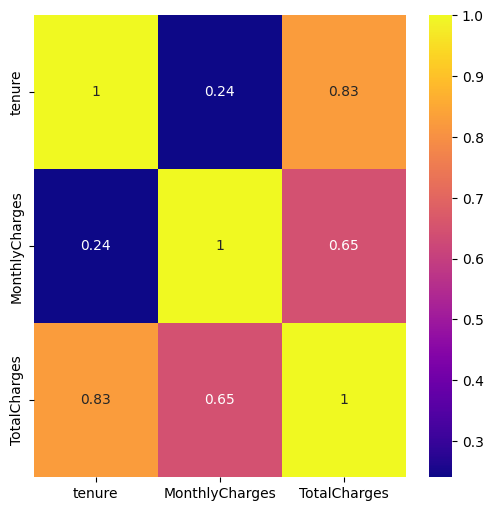

In [117]:
# correlation among the numerical variables
correlation2 = numerical_features.corr()

#visualize correlation using a heatmap
plt.figure(figsize=(6,6))
sn.heatmap(data=correlation2, annot=True, cmap='plasma')

> **Observation**
> > **Numerical Variables Correlation Insights**
>>> - There is a strong correlation `0.83` between the Total Charges for a Customer and their tenure in the company probably due to the sense that a customer who has a long tenure in a company is likely to have spent more than the one with a short tenure.
>>> - The correlation between Total Charges and Monthly Charges is more than average strong, `0.65` indicating that customers with a high total charges are likely to have higher monthly charges.
>>> - We have a weak positive relationship between monthly charges and tenure, `0.24`indicating that a small proportion of customers with a long tenure tend to have high monthly charges.

### Multi-Variate Data Analysis

#### Comparing the distribution of of `churn` against `TotalCharges` and the categorical variables

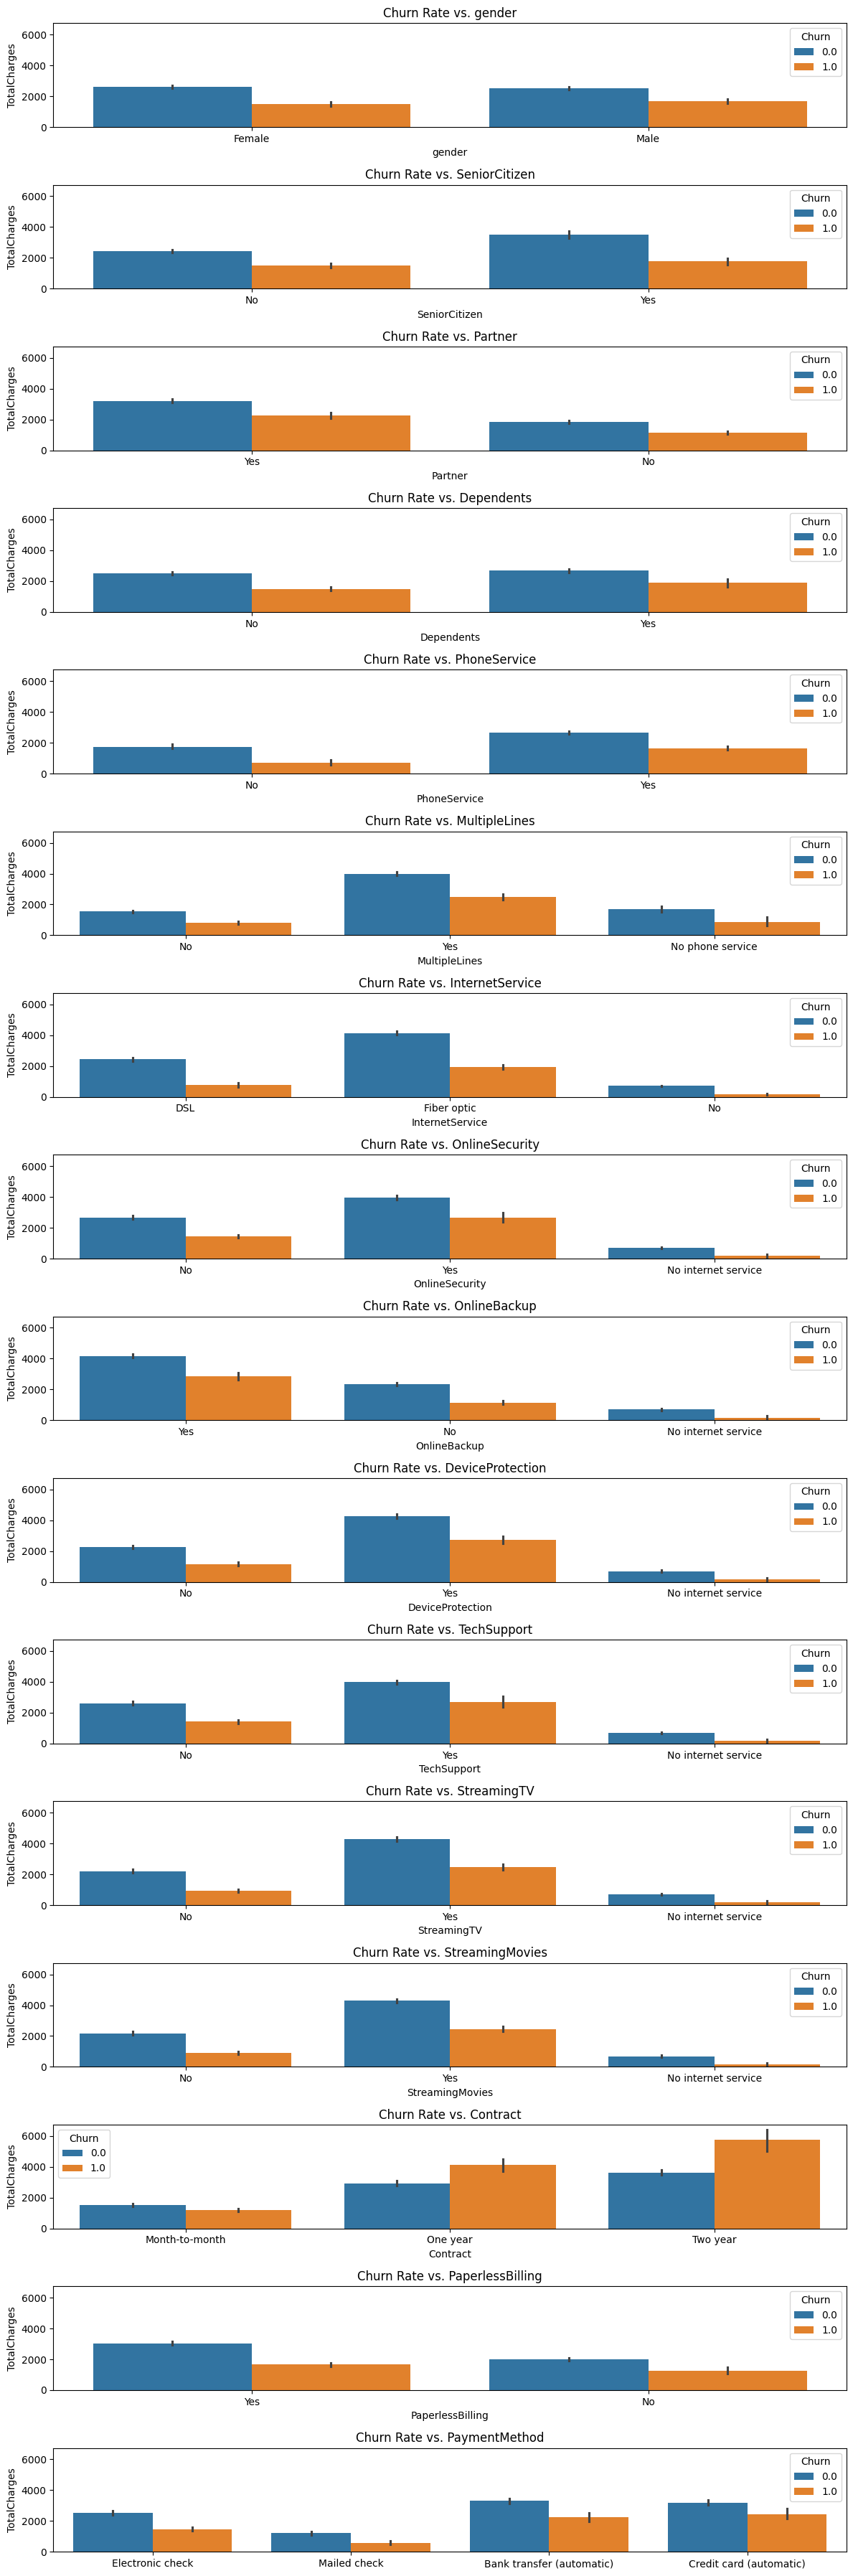

In [118]:
# Convert 'TotalCharges' column to numeric, replacing non-numeric values with NaN
combined_data['TotalCharges'] = pd.to_numeric(combined_data['TotalCharges'], errors='coerce')

# Define your numerical variable and categorical variables
numeric_variable = 'TotalCharges'

# Create subplots for each categorical variable
fig, axes = plt.subplots(len(categorical_features), figsize=(12, 36), sharey=True)

# Loop through each categorical variable and plot the churn rate by category
for i, cat_var in enumerate(categorical_features):
    sn.barplot(x=cat_var, y=numeric_variable, hue='Churn', data=combined_data, ax=axes[i])
    axes[i].set_title(f'Churn Rate vs. {cat_var}')

# Add labels and title
plt.xlabel('')
plt.ylabel(numeric_variable)
plt.tight_layout()
plt.show()



#### Comparing the distribution of of `churn` against `MonthlyCharges` and the categorical variables

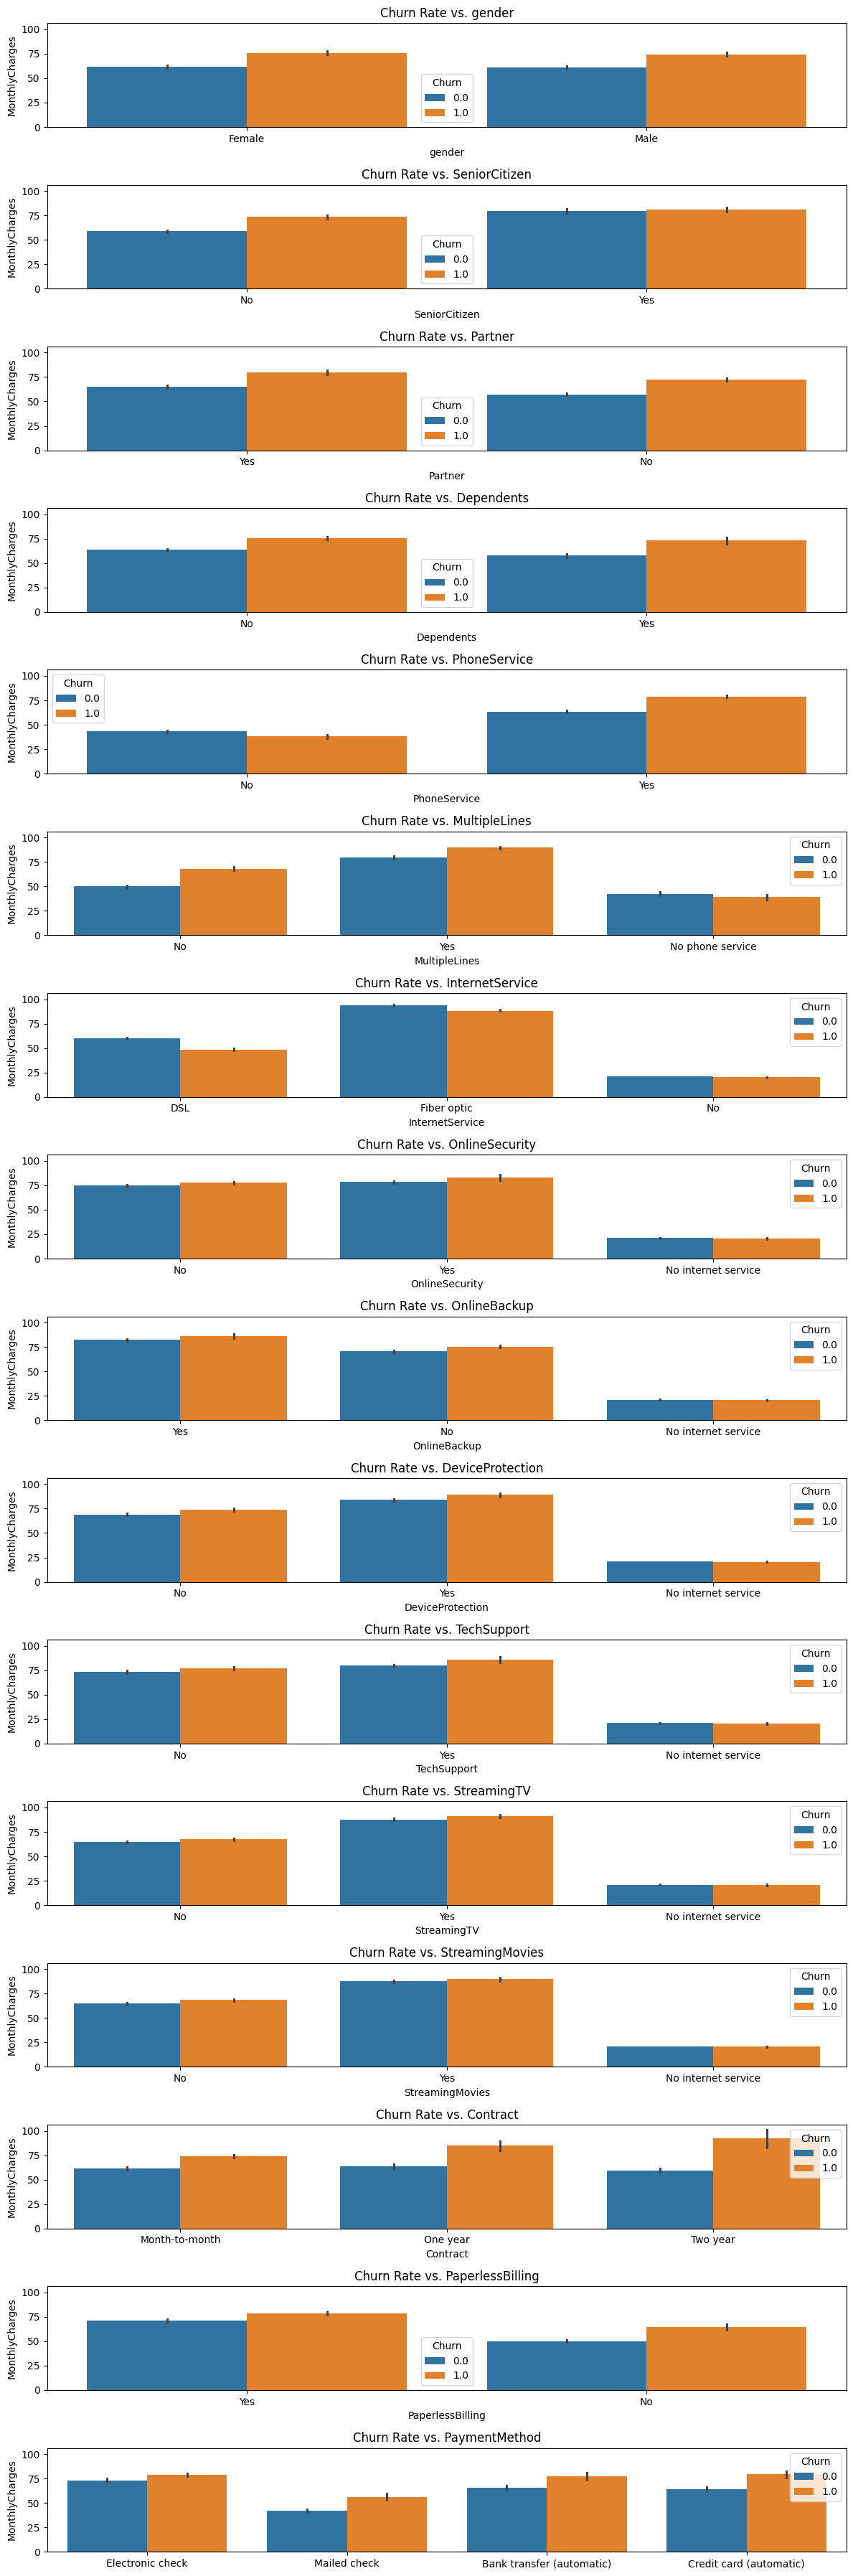

In [119]:
# Define your numerical variable and categorical variables
numeric_variable = 'MonthlyCharges'

# Create subplots for each categorical variable
fig, axes = plt.subplots(len(categorical_features), figsize=(12, 36), sharey=True)

# Loop through each categorical variable and plot the churn rate by category
for i, cat_var in enumerate(categorical_features):
    sn.barplot(x=cat_var, y=numeric_variable, hue='Churn', data=combined_data, ax=axes[i])
    axes[i].set_title(f'Churn Rate vs. {cat_var}')

# Add labels and title
plt.xlabel('')
plt.ylabel(numeric_variable)
plt.tight_layout()
plt.show()

#### Comparing the distribution of of `churn` against `tenure` and the categorical variables

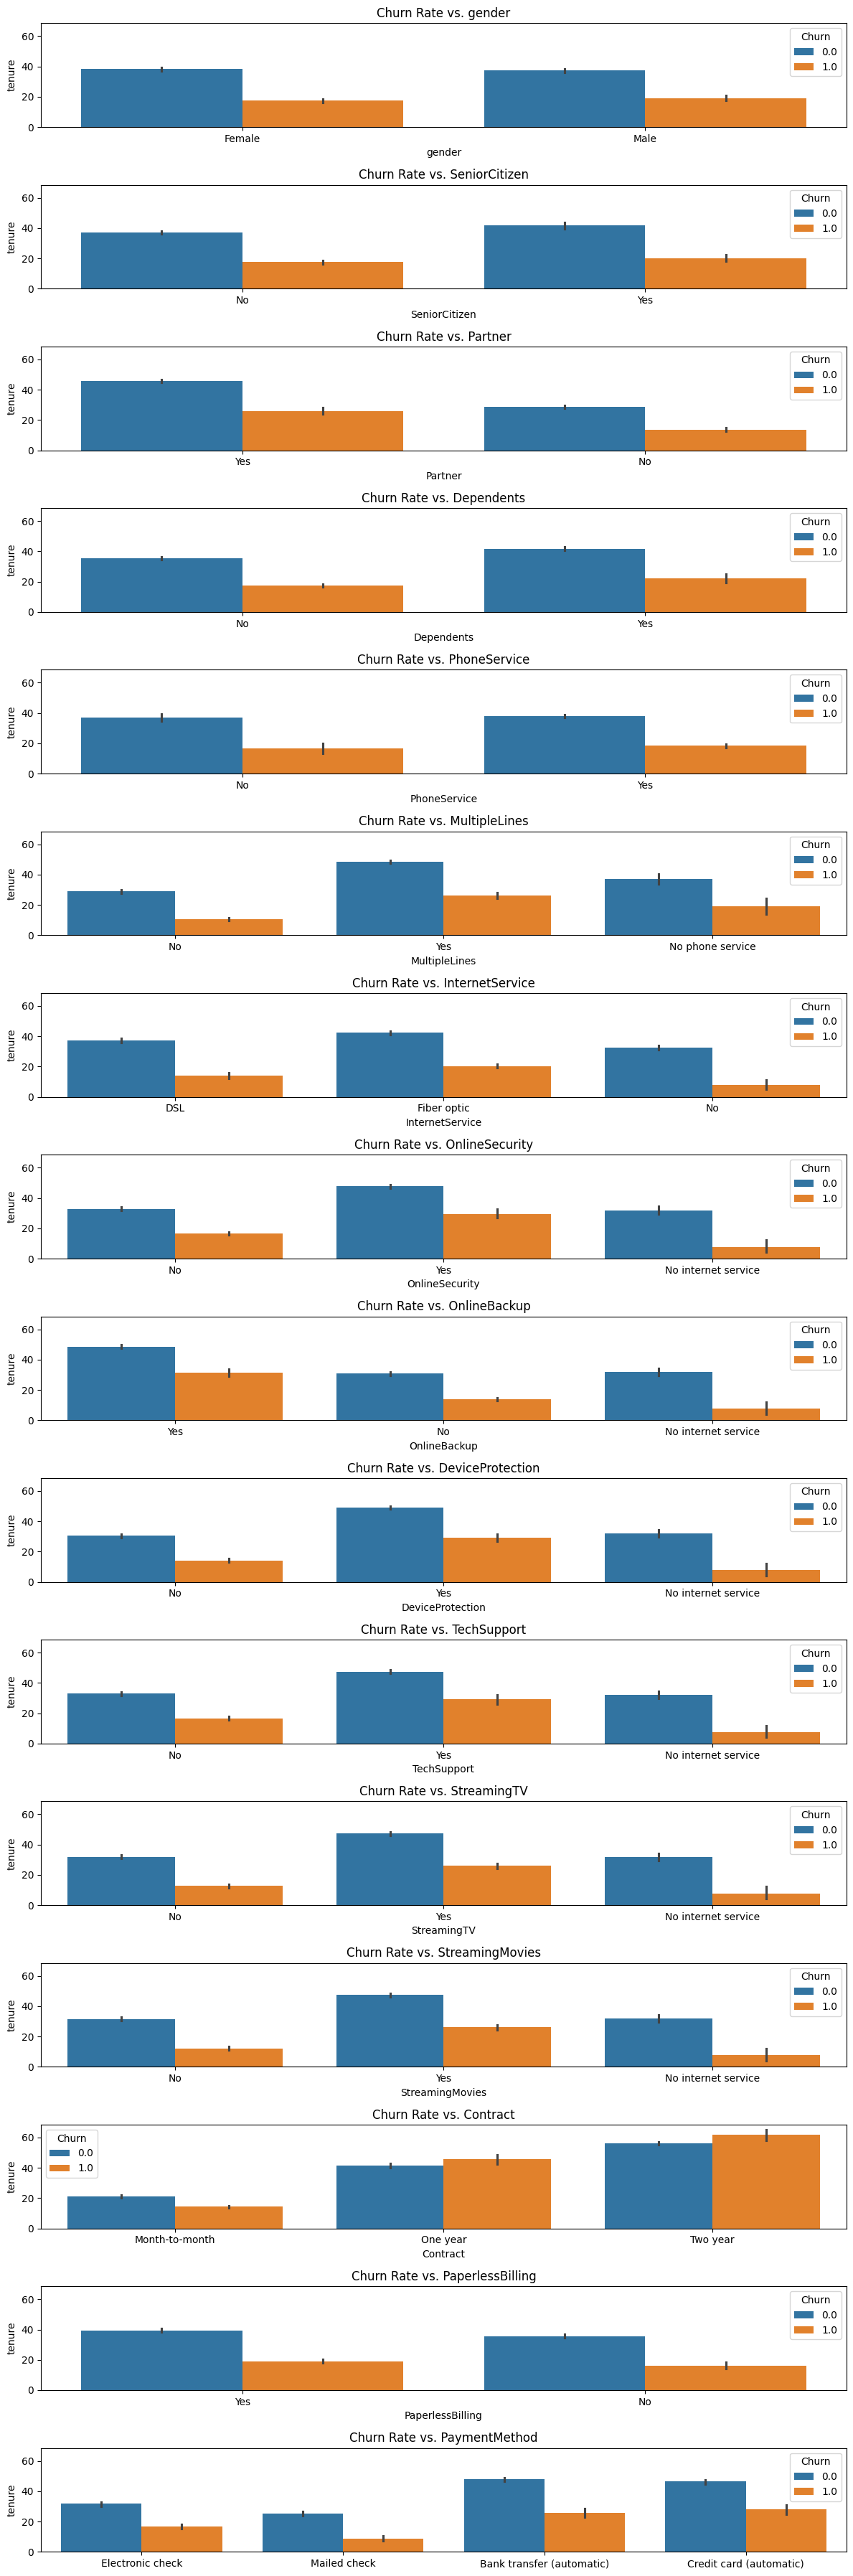

In [120]:
# Define your numerical variable and categorical variables
numeric_variable = 'tenure'

# Create subplots for each categorical variable
fig, axes = plt.subplots(len(categorical_features), figsize=(12, 36), sharey=True)

# Loop through each categorical variable and plot the churn rate by category
for i, cat_var in enumerate(categorical_features):
    sn.barplot(x=cat_var, y=numeric_variable, hue='Churn', data=combined_data, ax=axes[i])
    axes[i].set_title(f'Churn Rate vs. {cat_var}')

# Add labels and title
plt.xlabel('')
plt.ylabel(numeric_variable)
plt.tight_layout()
plt.show()

#### PairPlot Comparing the churn rates for pairs of binomial and numeric variables.

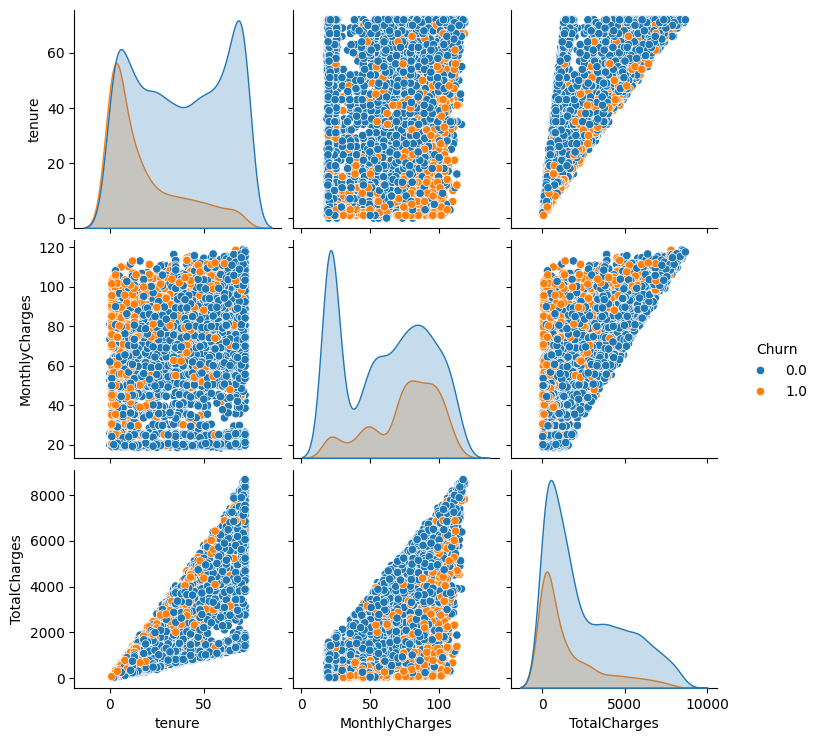

In [121]:
sn.pairplot(combined_data, hue='Churn')
plt.show()

> **Observations**
> > **`TotalCharges`, `MonthlyCharges` and `tenure` vs Categorical Variables Insights**
> > > - When `TotalCharges` and `tenure` increase, customers of all categories churn less than those that are retained except customer with `One Year Contract `, and `Two Year contracts` who churn more than those retained. This indicates that when TotalCharges and tenure increase, the customers at risk of churning are those with longer term contracts.
>>> - When `MonthlyCharges` increase, customers of all categories churn more than those that are retained except customers without; `Internet`, `InternetService` and `PhoneService`. This implies that Monthly charges are very sensitve to all customer categories except those customers without internet and phone services.


### 4. Answering the Analytical Questions

#### Q1: Does the monthly and Total charges affect the probability of a customer churning?

> **Definition**
>> Here we need to visualize the churn distribution and determine the correlation coefficient between `MonthlyCharge`, `TotalCharge` and `Churn`

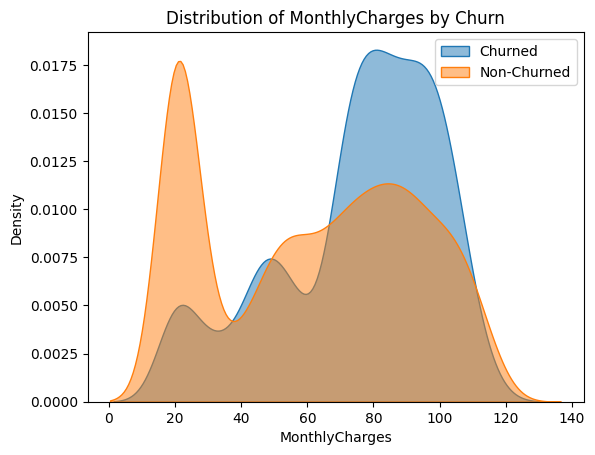

Correlation coefficient between MonthlyCharges and Churn: 0.2023


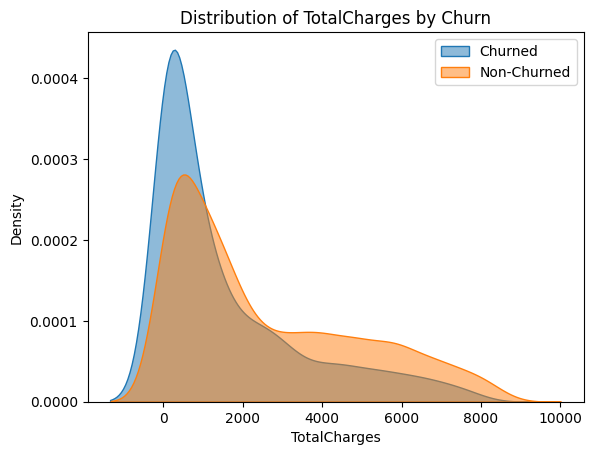

Correlation coefficient between TotalCharges and Churn: -0.1946


In [122]:
# Code

# Define features of interest
Interest_vars = combined_data[['MonthlyCharges','TotalCharges']]

# Bivariate analysis for features of interest
for feature in Interest_vars:

#test

    # Plot the distribution of the feature for churned and non-churned customers
    sn.kdeplot(
        combined_data[combined_data["Churn"] == 1][feature], label="Churned", shade=True, alpha=0.5
    )
    sn.kdeplot(
        combined_data[combined_data["Churn"] == 0][feature], label="Non-Churned", shade=True, alpha=0.5
    )
    
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.title(f"Distribution of {feature} by Churn")
    plt.legend()
    plt.show()

    # Calculate the correlation coefficient between the feature and Churn
    correlation = combined_data[feature].corr(combined_data["Churn"])
    print(f"Correlation coefficient between {feature} and Churn: {correlation:.4f}")

> **Answer to Question 1**
>> - As seen from the above visualization and correlation analysis, when `MonthlyCharges` increase, the associated rate of customers that stop using the company's product and services increase. This is supportes by the corresponding correlation coefficient of `0.1883`, though weak, it shows that monthly charges affect the rate of customer churn.
>
>> - Customers with lower `TotalCharges` are at a higher risk of churning than custmers with higher total charges. The `-0.196` correlation coefficient reinforces this accertion despite being a week negative relation.
>
>> - Therefore, the `TotalCharges` and `MonthlyCharges` variables affect the rate of customer churn in opposing directions and the effects are mild.

#### Q2: How does contract duration affect the probability of a customer churning?

> **Definition**
>> We will visualize the churn rates among the various categories of customer `Contracts` to establish if there is a relationship between the two variables.


**Churn Percentage by Contract Category:
         Contract      Churn
0  Month-to-month  43.148688
1        One year  11.563981
2        Two year   2.413516


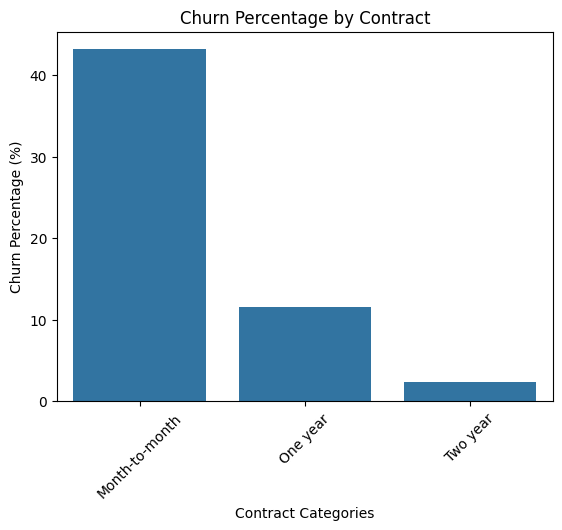

In [123]:
#code
C_feature = combined_data['Contract']
# Calculate churn percentage for contracts
contract_churn_pct = (
    combined_data.groupby(C_feature)["Churn"].mean() * 100
).reset_index()

# Sort categories by churn percentage
contract_churn_pct = contract_churn_pct.sort_values(by="Churn", ascending=False)

# Print results
print(f"\n**Churn Percentage by Contract Category:")
print(contract_churn_pct)

#test

# Plot the churn percentage by category
sn.barplot(x="Contract", y="Churn", data=contract_churn_pct)
plt.xlabel('Contract Categories')
plt.ylabel("Churn Percentage (%)")
plt.title(f"Churn Percentage by Contract")
plt.xticks(rotation= 45 )
plt.show()

> **Answer to Question 2**
>> - The percentage of customers with a `Month-to-month` contract who churn is `43.8%`, for those with a `One year` contract, its is `11.99%` and those with a `Two year` contract, is at `4.02%`.
>> - This clearly indicates that customers with a longer term contract are less likely to be at churn risk and it's the customers with a Month-to-month contract that pose the greatest churn risk.

#### Q3: How likely are customers with a `tenure` more than 5 years likely to churn?

> **Definition**
>> We will calculate and visualize the churn rate among customers with a `tenure > 5 years`.

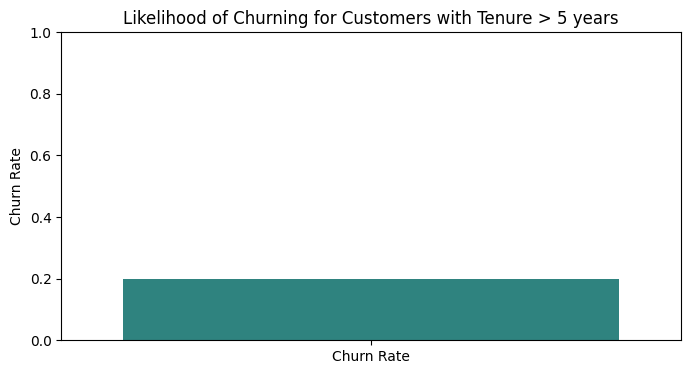

Churn Rate for Customers with Tenure > 5 years: 20.04%


In [124]:
#code
# Filter customers with tenure more than 5 years
long_tenure_customers = combined_data[combined_data['tenure'] > 5]

# Calculate the churn rate for customers with tenure > 5 years
churn_rate_long_tenure = long_tenure_customers['Churn'].mean()

#test

# Visualize the likelihood of churning
plt.figure(figsize=(8, 4))
sn.barplot(x=['Churn Rate'], y=[churn_rate_long_tenure], palette='viridis')
plt.title('Likelihood of Churning for Customers with Tenure > 5 years')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)
plt.show()

print(f'Churn Rate for Customers with Tenure > 5 years: {churn_rate_long_tenure:.2%}')

> **Answer to Question 3**
>> - Customers with a `tenure` of more than 5 years have a 20% likelihood of stopping the usage of the company's products or services.

#### Q4: Which payment method has customers with highest churn rate?

> **Definition**
>> We will consider the churn rates for all the payment method categories and determine the one with the highest rate.


**Churn Percentage by PaymentMethod Category:
               PaymentMethod      Churn
2           Electronic check  44.614479
3               Mailed check  18.794326
0  Bank transfer (automatic)  17.600000
1    Credit card (automatic)  15.412844


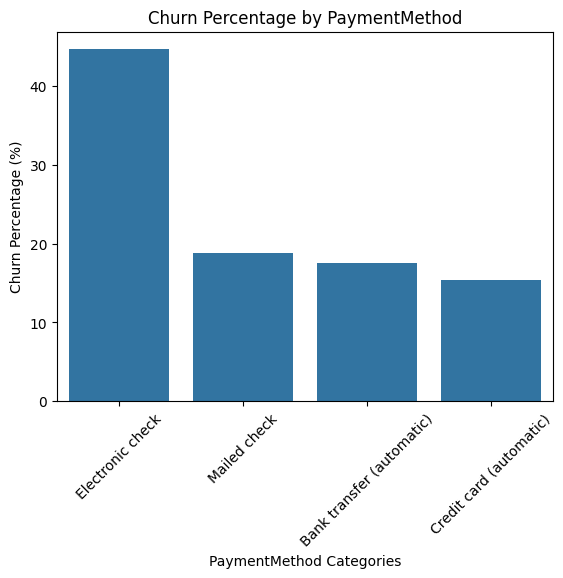

In [125]:
#code
P_feature = combined_data['PaymentMethod']
# Calculate churn percentage for contracts
contract_churn_pct = (
    combined_data.groupby(P_feature)["Churn"].mean() * 100
).reset_index()

# Sort categories by churn percentage
contract_churn_pct = contract_churn_pct.sort_values(by="Churn", ascending=False)

# Print results
print(f"\n**Churn Percentage by PaymentMethod Category:")
print(contract_churn_pct)

#test

# Plot the churn percentage by category
sn.barplot(x="PaymentMethod", y="Churn", data=contract_churn_pct)
plt.xlabel('PaymentMethod Categories')
plt.ylabel("Churn Percentage (%)")
plt.title(f"Churn Percentage by PaymentMethod")
plt.xticks(rotation= 45 )
plt.show()


> **Answer to Question 4**
>> - Customers who paid via `electronic check` were at the highest risk of churning as `44.25%` of the customers with this payment option churned as compared to custmers who paid through; `Mailed check`, `Credit card (automatic)`, and `Bank transfer(automatic)` whose churn rates were, `19.96%`, `17.78%` and `17.35%` respectively.

#### Q5: Which Demographic factors most affected the customer churn rate?

> **Definition**
>> We will consider the churn rates for the`gender`, `SeniorCitizen`, `Dependant` and `Partner` variables and list the top churn rate determinants.


**Churn Percentage by gender Category:
   gender      Churn
0  Female  26.610306
1    Male  26.387803


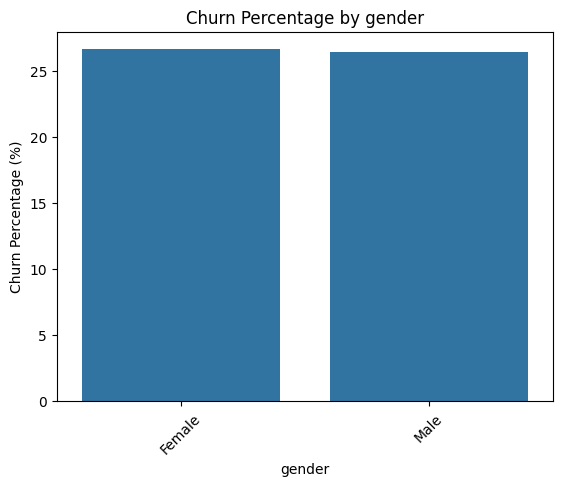


**Churn Percentage by SeniorCitizen Category:
  SeniorCitizen      Churn
1           Yes  41.514042
0            No  23.585129


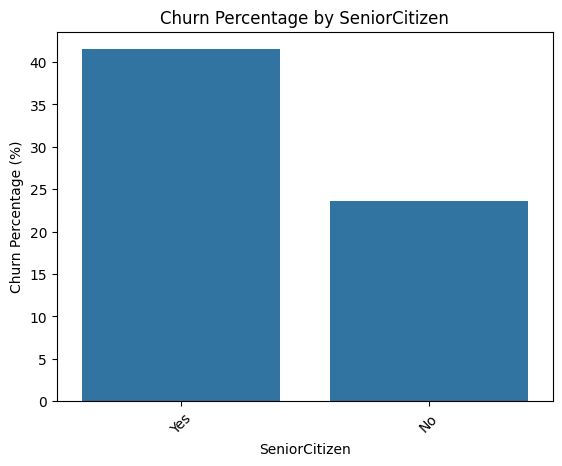


**Churn Percentage by Dependents Category:
  Dependents      Churn
0         No  31.571388
1        Yes  15.182575


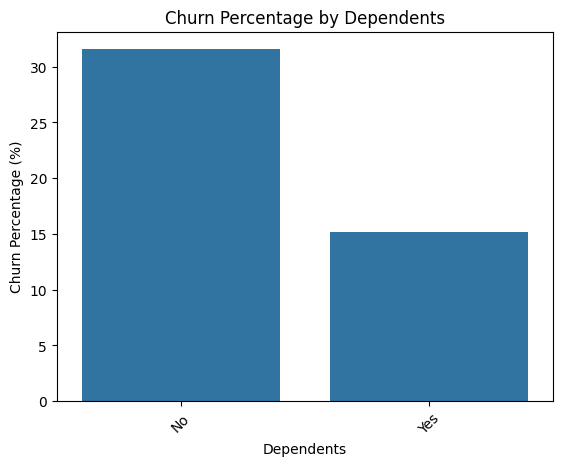


**Churn Percentage by Partner Category:
  Partner      Churn
0      No  32.572534
1     Yes  20.105820


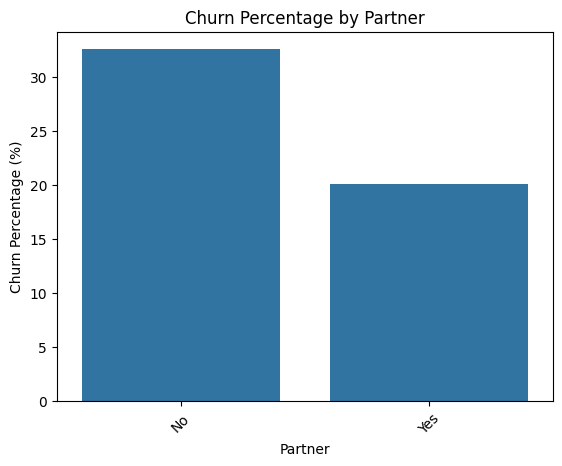

In [126]:
#code

# Define demographic features
Demographic_features = combined_data[['gender','SeniorCitizen','Dependents','Partner']]

# Function for bivariate analysis of demographic features
def analyze_Demographic_feature(feature):
    # Calculate churn percentage for each category
    churn_pct_by_category = (
        combined_data.groupby(feature)["Churn"].mean() * 100
    ).reset_index()
    
    # Sort categories by churn percentage
    churn_pct_by_category = churn_pct_by_category.sort_values(by="Churn", ascending=False)

    # Print results
    print(f"\n**Churn Percentage by {feature} Category:")
    print(churn_pct_by_category)

    # Plot the churn percentage by category
    sn.barplot(x=feature, y="Churn", data=churn_pct_by_category)
    plt.xlabel(feature)
    plt.ylabel("Churn Percentage (%)")
    plt.title(f"Churn Percentage by {feature}")
    plt.xticks(rotation= 45 )
    plt.show()

# Loop through each categorical feature and perform bivariate analysis
for feature in Demographic_features:
    analyze_Demographic_feature(feature)

> **Answer to Question 5**
>> - Among the `Demographic Categories`, users who were `SeniorCitizens` churned most by `43.02%`, followed by users without `Partners` at `33.24%` and users without `Dependents` were the third highest churning category with a `32.29%` rate.
>> - These three categories were the top demographic factors increasing the probability of a customer churning.

#### Q6: Which customer service had the highest churn rate?

> **Definition**
>> Here we will consider and visualize the churn rates for all the customer subscribed services then determine the one with the highest churn rate.

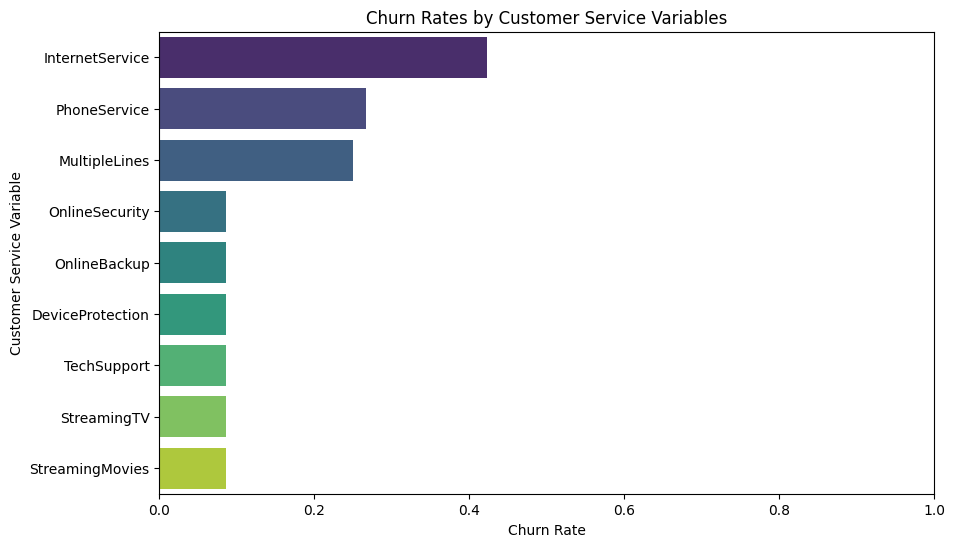

The customer service variable with the highest churn rate is "InternetService" with a churn rate of 42.32%


In [127]:
#code
# List of customer service variables to analyze
CS_variables = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','PhoneService','MultipleLines', 'InternetService']

# Create a dictionary to store churn rates for each service variable
churn_rates = {}

# Calculate and store the churn rate for each service variable
for service_var in CS_variables:
    churn_rate = combined_data.groupby(service_var)['Churn'].mean().reset_index()
    churn_rates[service_var] = churn_rate.iloc[1]['Churn']  # Assuming 'Yes' represents churn

# Convert the dictionary into a DataFrame for visualization
churn_df = pd.DataFrame.from_dict(churn_rates, orient='index', columns=['Churn Rate'])
churn_df = churn_df.sort_values(by='Churn Rate', ascending=False)

# Visualize the churn rates for customer service variables
plt.figure(figsize=(10, 6))
sn.barplot(x='Churn Rate', y=churn_df.index, data=churn_df, palette='viridis')
plt.title('Churn Rates by Customer Service Variables')
plt.xlabel('Churn Rate')
plt.ylabel('Customer Service Variable')
plt.xlim(0, 1)
plt.show()

# Print the customer service variable with the highest churn rate
highest_churn_service = churn_df.index[0]
highest_churn_rate = churn_df.iloc[0]['Churn Rate']
print(f'The customer service variable with the highest churn rate is "{highest_churn_service}" with a churn rate of {highest_churn_rate:.2%}')

> **Answer to Question 6**
>> - The customer service variable with the highest churn rate is `InternetService` with a churn rate of 42.10%.

### 5. Testing the Hypothesis

> **Null Hypotheis:** 
>> Contract duration has no effect on the probability of a customer churning
>
> **Alternative Hypothesis**
>> Contract duration affects the rate of customer churn

In [128]:
#code
# Create a contingency table of contract duration and churn
contingency_table = pd.crosstab(combined_data["Contract"], combined_data["Churn"])

# Perform chi-square test
scipy.stats.chi2_contingency
chi_square, p_value, *_ = scipy.stats.chi2_contingency(contingency_table)

# Print the results
print(f"Chi-square statistic: {chi_square:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpret the results
if p_value > 0.05:
  print("Fail to reject the null hypothesis. Contract duration has no significant effect on the probability of customer churn.")
else:
  print("Reject the null hypothesis. Contract duration has a significant effect on the probability of customer churn.")

Chi-square statistic: 881.6209
p-value: 0.0000
Reject the null hypothesis. Contract duration has a significant effect on the probability of customer churn.


> **Conclusion of Hypothesis Test**
>> - Reject the null hypothesis. Contract duration has a significant effect on the probability of customer churn.

## Data Preparation

### 1. Splitting Data

In [130]:
combined_data = combined_data.dropna(subset=['Churn'])

#### Splitting the Data into input(x) and response(y) variables

In [131]:
# split the data into input(x) variable

#code
X = combined_data.drop("Churn", axis = 1)

#test
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5042 entries, 0 to 5042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5042 non-null   object 
 1   SeniorCitizen     5042 non-null   object 
 2   Partner           5042 non-null   object 
 3   Dependents        5042 non-null   object 
 4   tenure            5042 non-null   int64  
 5   PhoneService      5042 non-null   object 
 6   MultipleLines     4773 non-null   object 
 7   InternetService   5042 non-null   object 
 8   OnlineSecurity    4391 non-null   object 
 9   OnlineBackup      4391 non-null   object 
 10  DeviceProtection  4391 non-null   object 
 11  TechSupport       4391 non-null   object 
 12  StreamingTV       4391 non-null   object 
 13  StreamingMovies   4391 non-null   object 
 14  Contract          5042 non-null   object 
 15  PaperlessBilling  5042 non-null   object 
 16  PaymentMethod     5042 non-null   object 
 17  

In [132]:
# split the data into output(y) variable

#code
y = combined_data['Churn']

#test
y.info()

<class 'pandas.core.series.Series'>
Index: 5042 entries, 0 to 5042
Series name: Churn
Non-Null Count  Dtype  
--------------  -----  
5042 non-null   float64
dtypes: float64(1)
memory usage: 78.8 KB


#### Split the data into Training and Evaluation Datasets

In [133]:
#splitting the dataset into training and evaluation datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 2. Feature Engineering

> We already generated `numerical_features` that consist of the variables with numeric values and the `Categorical_features` that consist of all variables with categorical values in this dataset

In [135]:
#listing Numerical Columns
print(f"Numerical Columns include:{numerical_features.columns}")

Numerical Columns include:Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


In [141]:
#listing Categorical Columns
print(f"Categorical Columns include:{categorical_features}")

Categorical Columns include:Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


#### 3. Pipelines

##### Data Pre-processing Pipeline

> This pipeline will enable us to impute, encode, scale, Transform and Preprecess our datasets before training our Machine Learning Models with it. This will ensure that our data is suitable for the models to give optimal results.

<Axes: >

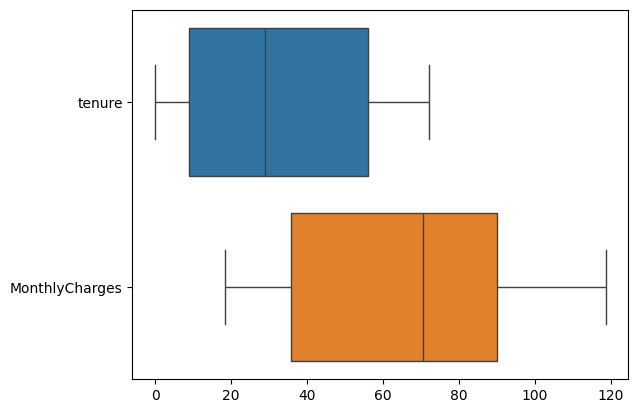

In [137]:
#distribution of tenure and monthly charges variables
Tenure_and_MonthlyC=combined_data[['tenure','MonthlyCharges']]
sn.boxplot(data=Tenure_and_MonthlyC, orient='h')

<Axes: xlabel='TotalCharges'>

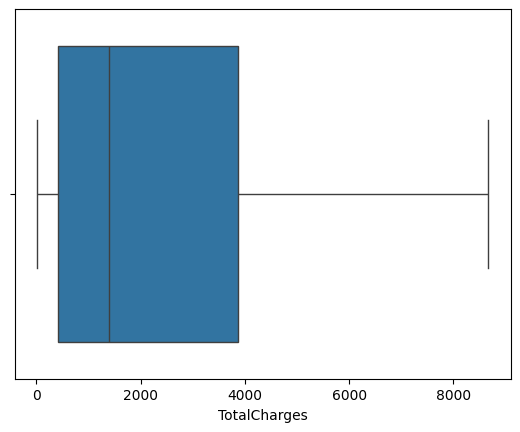

In [138]:
#distribution of TotalCharges Variable
sn.boxplot(data=combined_data.TotalCharges, orient='h')

**Observation**
> - Our `Numerical Variables` don't have missing variables except the `TotalCharges`variable.
> - From the `Boxplots`above, our numerical variables don't have outliers. 
> - Only `tenure` has 8 entries that have the value of `0`.

##### Machine Learning Pipeline

In [139]:
# Define numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
            ('scaler', StandardScaler())  # Scaling numerical features
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding categorical features
        ]), categorical_features)
    ])

# Define the machine learning models
models = [
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Support Vector Machine', SVC()),
    ('Logistic Regression', LogisticRegression())
]

# Create a machine learning pipeline for each model
for model_name, model in models:
    # Create the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Preprocess the features
        ('model', model)  # The machine learning model
    ])

    # Train the model
    pipeline.fit(x_train, y_train)

    # Predictions on the test set
    y_pred = pipeline.predict(x_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Display results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)
    print("--------------------------------------------------------")


Model: Random Forest
Accuracy: 0.7859
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.89      0.86       742
         1.0       0.62      0.50      0.55       267

    accuracy                           0.79      1009
   macro avg       0.72      0.69      0.71      1009
weighted avg       0.77      0.79      0.78      1009

--------------------------------------------------------
Model: Gradient Boosting
Accuracy: 0.8117
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.90      0.88       742
         1.0       0.67      0.58      0.62       267

    accuracy                           0.81      1009
   macro avg       0.76      0.74      0.75      1009
weighted avg       0.80      0.81      0.81      1009

--------------------------------------------------------
Model: Support Vector Machine
Accuracy: 0.8028
Classification Report:
               precision    recall

In [142]:
#feature engineering
class LogTransformer:
    def __init__(self, constant=1e-5):
        self.constant = constant

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.log1p(X + self.constant)

# Numeric pipeline
numerical_pipeline = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('log_transformation', FunctionTransformer(LogTransformer().transform)),
    ('scaler', RobustScaler()),
    
])



# Categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder()),
])

# Combine the numeric and categorical pipelines using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('numerical_pipeline', numerical_pipeline, numerical_features),
    ('categorical_pipeline', categorical_pipeline, categorical_features),
])


In [143]:
#label encoding
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training set
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform the testing set using the fitted label encoder
y_test_encoded = label_encoder.transform(y_test)


In [144]:
#Random Forest 
# Create a pipeline with preprocessor and DecisionTreeClassifier
decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Fit the pipeline to the training data
decision_tree_pipeline.fit(x_train, y_train_encoded)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transformation',
                                                                   FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x000001F4098D6090>>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['tenure', 'MonthlyCharges', 'TotalCharges']...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [145]:
#Gradient Boosting 
# Create a pipeline with preprocessor and DecisionTreeClassifier
decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

# Fit the pipeline to the training data
decision_tree_pipeline.fit(x_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transformation',
                                                                   FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x000001F4098D6090>>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['tenure', 'MonthlyCharges', 'TotalCharges']...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier', GradientBoostingClassifier())])

In [146]:
#SVC
# Create a pipeline with preprocessor and DecisionTreeClassifier
decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

# Fit the pipeline to the training data
decision_tree_pipeline.fit(x_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transformation',
                                                                   FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x000001F4098D6090>>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['tenure', 'MonthlyCharges', 'TotalCharges']...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier', SVC())])

In [147]:
#logistic Regression
# Create a pipeline with preprocessor and DecisionTreeClassifier
decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Fit the pipeline to the training data
decision_tree_pipeline.fit(x_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transformation',
                                                                   FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x000001F4098D6090>>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['tenure', 'MonthlyCharges', 'TotalCharges']...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier', LogisticRegression())])

In [148]:
# model comparision by classification report
# Define the machine learning models
models = [
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Support Vector Machine', SVC()),
    ('Logistic Regression', LogisticRegression())
]

# Create a machine learning pipeline for each model
for model_name, model in models:
    # Create the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Preprocess the features
        ('model', model)  # The machine learning model
    ])

    # Train the model
    pipeline.fit(x_train, y_train)

    # Predictions on the test set
    y_pred = pipeline.predict(x_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Display results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)
    print("--------------------------------------------------------")

Model: Random Forest
Accuracy: 0.7899
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.89      0.86       742
         1.0       0.63      0.51      0.56       267

    accuracy                           0.79      1009
   macro avg       0.73      0.70      0.71      1009
weighted avg       0.78      0.79      0.78      1009

--------------------------------------------------------
Model: Gradient Boosting
Accuracy: 0.8117
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.90      0.88       742
         1.0       0.67      0.58      0.62       267

    accuracy                           0.81      1009
   macro avg       0.76      0.74      0.75      1009
weighted avg       0.80      0.81      0.81      1009

--------------------------------------------------------
Model: Support Vector Machine
Accuracy: 0.8097
Classification Report:
               precision    recall

In [149]:
#Data Balancing
y_train.value_counts()

Churn
0.0    2964
1.0    1069
Name: count, dtype: int64

In [152]:
#Balance data by oversampling

# Instantiate RandomOverSampler
sampler = RandomOverSampler(random_state=42)

# Fit and apply RandomOverSampler to the training data
x_train_resampled, y_train_resampled = sampler.fit_resample(x_train, y_train_encoded)

#test
pd.DataFrame(y_train_resampled).value_counts()

0    2964
1    2964
Name: count, dtype: int64

In [153]:
# checking if there is an improvement after balancing the data
# model comparision by classification report
# Define the machine learning models
models = [
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Support Vector Machine', SVC()),
    ('Logistic Regression', LogisticRegression())
]

# Create a machine learning pipeline for each model
for model_name, model in models:
    # Create the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Preprocess the features
        ('model', model)  # The machine learning model
    ])

    # Train the model
    pipeline.fit(x_train_resampled, y_train_resampled)

    # Predictions on the test set
    y_pred = pipeline.predict(x_test)
# Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Display results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)
    print("--------------------------------------------------------")

Model: Random Forest
Accuracy: 0.7760
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.85      0.85       742
         1.0       0.58      0.56      0.57       267

    accuracy                           0.78      1009
   macro avg       0.71      0.71      0.71      1009
weighted avg       0.77      0.78      0.77      1009

--------------------------------------------------------
Model: Gradient Boosting
Accuracy: 0.7582
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.75      0.82       742
         1.0       0.53      0.79      0.63       267

    accuracy                           0.76      1009
   macro avg       0.72      0.77      0.73      1009
weighted avg       0.81      0.76      0.77      1009

--------------------------------------------------------
Model: Support Vector Machine
Accuracy: 0.7532
Classification Report:
               precision    recall

In [154]:
#feature selection
pd.DataFrame(preprocessor.fit_transform(x_train))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
0,-1.590951,-0.015537,-1.360786,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.300248,-1.374423,-0.174392,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.953250,0.206900,-0.547413,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.277482,-1.329790,-0.148616,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.497149,0.270883,0.692194,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4028,-1.590951,0.070952,-1.325304,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4029,-0.019033,0.320450,0.281270,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4030,0.176276,-1.361108,-0.254700,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4031,-0.254390,-1.369078,-0.589404,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [155]:
# Models to evaluate
models = {
    'Gradient Boost': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC()
}

# Feature selection using SelectKBest
selection = SelectKBest(mutual_info_classif, k=50)

# Create and evaluate pipelines for each model
for model_name, classifier in models.items():  # Use items() to iterate over keys and values
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', selection),
        ('classifier', classifier)
    ])
# Train the model
    pipeline.fit(x_train_resampled, y_train_resampled)

    # Predictions on the test set
    y_pred = pipeline.predict(x_test)
# Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Display results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)
    print("--------------------------------------------------------")

Model: Gradient Boost
Accuracy: 0.7582
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.75      0.82       742
         1.0       0.53      0.79      0.63       267

    accuracy                           0.76      1009
   macro avg       0.72      0.77      0.73      1009
weighted avg       0.81      0.76      0.77      1009

--------------------------------------------------------
Model: Random Forest
Accuracy: 0.7800
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.85      0.85       742
         1.0       0.58      0.58      0.58       267

    accuracy                           0.78      1009
   macro avg       0.72      0.72      0.72      1009
weighted avg       0.78      0.78      0.78      1009

--------------------------------------------------------
Model: SVC
Accuracy: 0.7483
Classification Report:
               precision    recall  f1-score   support



In [156]:
selection.get_support(indices=True)

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52],
      dtype=int64)

In [157]:
#training the balanced Random Forest classifier model
# RandomForestClassifier pipeline with balancing
rf_pipeline_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_importance', selection),
    
    ('Random Forest', RandomForestClassifier(random_state=42))
])

# Fit the pipeline on the resampled training data
rf_pipeline_balanced.fit(x_train_resampled, y_train_resampled)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transformation',
                                                                   FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x000001F4098D6090>>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['tenure', 'MonthlyCharges', 'TotalCharges']...
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('feature_importance',
                 SelectKBest(k=50,
                             score_func=<function mutual_info_classif at 0x000001F41873D120>)),
                ('Random Forest', RandomForestClassifier(random_state=42))])

In [159]:
#rf confusion matrix
# Predict on the test set
y_pred_rf_balanced = rf_pipeline_balanced.predict(x_test)

# Create confusion matrix
conf_matrix_rf_balanced = confusion_matrix(y_test_encoded, y_pred_rf_balanced)
conf_matrix_rf_balanced 

array([[640, 102],
       [115, 152]], dtype=int64)

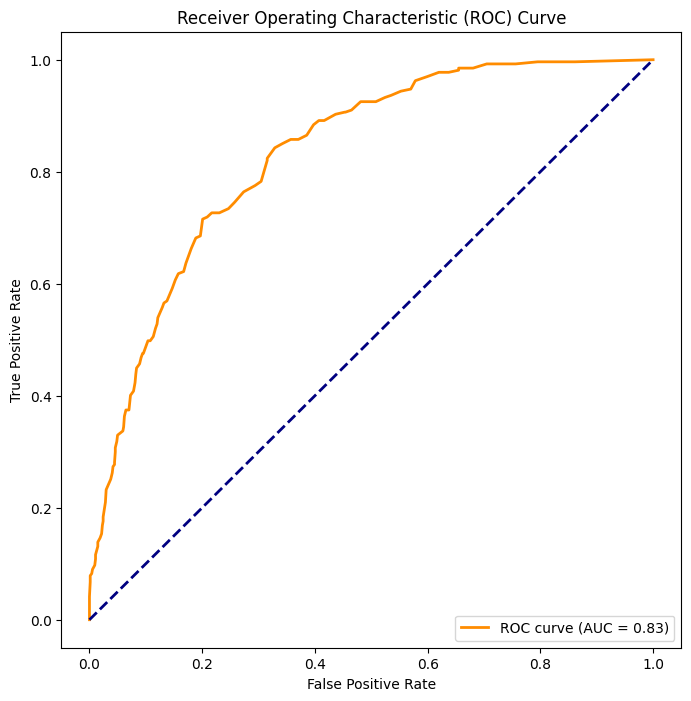

In [161]:
# Assuming `rf_pipeline_balanced` is your trained model
y_pred_prob = rf_pipeline_balanced.predict_proba(x_test)[:, 1]  # Probability of positive class

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_prob)
roc_auc = roc_auc_score(y_test_encoded, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [163]:
df = pd.DataFrame(zip(fpr, tpr, thresholds), columns=['False Positive', 'True Positive', 'Threshold'])
df.tail(50)

,False Positive,True Positive,Threshold
55,0.171159,0.636704,0.460000
56,0.176550,0.651685,0.450000
57,0.180593,0.662921,0.440000
58,0.188679,0.681648,0.430000
59,0.196765,0.685393,0.420000
60,0.200809,0.715356,0.410000
61,0.208895,0.719101,0.400000
62,0.216981,0.726592,0.390000
63,0.230458,0.726592,0.380000
64,0.246631,0.734082,0.370000


#### Hyperparameter Tuning and Retraining with RandomizedSearchCV and GridSearchCV

In [164]:
#RandomizedSearchCV

# Define the parameter distributions
param_dist = {
    'Random Forest__n_estimators': [50, 100, 200, 300],
    'Random Forest__max_depth': [None, 10, 20, 30],
    'Random Forest__min_samples_split': [2, 5, 10],
    'Random Forest__min_samples_leaf': [1, 2, 4]
}

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(rf_pipeline_balanced, param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the random search to the data
random_search.fit(x_train_resampled, y_train_resampled)

# Print the best parameters
print("Best Parameters:", random_search.best_params_)

# Get the best model from the random search
best_rf_model_random = random_search.best_estimator_

# Predict on the test set
y_pred_rf_random = best_rf_model_random.predict(x_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf_random))


Best Parameters: {'Random Forest__n_estimators': 300, 'Random Forest__min_samples_split': 5, 'Random Forest__min_samples_leaf': 2, 'Random Forest__max_depth': None}
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       742
           1       0.57      0.66      0.61       267

    accuracy                           0.78      1009
   macro avg       0.72      0.74      0.73      1009
weighted avg       0.79      0.78      0.78      1009



In [165]:
#GridSearchCV
# Define the parameter grid
param_grid = {
    'Random Forest__n_estimators': [50, 100, 200],
    'Random Forest__max_depth': [None, 10, 20],
    'Random Forest__min_samples_split': [2, 5],
    'Random Forest__min_samples_leaf': [1, 2]
}

# Create the grid search
grid_search = GridSearchCV(rf_pipeline_balanced, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(x_train_resampled, y_train_resampled)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model from the grid search
best_rf_model_grid = grid_search.best_estimator_

# Predict on the test set
y_pred_rf_grid = best_rf_model_grid.predict(x_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf_grid))


Best Parameters: {'Random Forest__max_depth': 20, 'Random Forest__min_samples_leaf': 1, 'Random Forest__min_samples_split': 2, 'Random Forest__n_estimators': 50}
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       742
           1       0.59      0.57      0.58       267

    accuracy                           0.78      1009
   macro avg       0.72      0.71      0.71      1009
weighted avg       0.78      0.78      0.78      1009

